In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Import API key
from api_keys import api_key

In [4]:
# Loading files used in this analysis
tracts_df = pd.read_csv('500_Census_Tracts.csv')
acs16_df = pd.read_csv('ACS_2016.csv')
tracts_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,23.3,"(20.6, 26.3)",31.3,"(30.3, 32.5)",...,"(83.4, 86.6)",20.0,"(18.5, 21.7)",45.5,"(44.3, 46.5)",5.6,"( 5.1, 6.1)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)"
1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,28.5,"(25.2, 31.7)",30.2,"(29.0, 31.4)",...,"(81.9, 85.6)",20.6,"(18.8, 22.5)",44.5,"(43.2, 45.7)",5.9,"( 5.3, 6.5)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)"
2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,23.9,"(20.5, 27.6)",31.7,"(30.3, 33.0)",...,"(82.3, 86.8)",19.3,"(17.6, 21.4)",45.7,"(44.2, 47.0)",5.7,"( 5.1, 6.4)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)"
3,AL,Birmingham,107000,1073000500,0107000-01073000500,2864,25.8,"(22.0, 29.9)",35.6,"(34.1, 37.0)",...,"(82.1, 86.5)",21.8,"(19.8, 24.0)",46.1,"(44.5, 47.4)",7.7,"( 6.9, 8.6)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)"
4,AL,Birmingham,107000,1073000700,0107000-01073000700,2577,29.4,"(24.8, 34.2)",37.2,"(35.8, 38.6)",...,"(82.2, 87.1)",25.1,"(22.9, 27.6)",48.3,"(46.6, 49.7)",9.5,"( 8.4, 10.6)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)"


## Selecting a smaller set of variables from the 2016 Census Tracts CDC dataset

(array([3.000e+00, 5.900e+01, 7.310e+02, 2.377e+03, 3.503e+03, 3.807e+03,
        3.891e+03, 3.392e+03, 2.709e+03, 2.395e+03, 1.811e+03, 1.171e+03,
        7.590e+02, 3.670e+02, 1.420e+02, 5.300e+01, 2.200e+01, 1.200e+01,
        5.000e+00, 1.000e+00]),
 array([ 4.1  ,  5.365,  6.63 ,  7.895,  9.16 , 10.425, 11.69 , 12.955,
        14.22 , 15.485, 16.75 , 18.015, 19.28 , 20.545, 21.81 , 23.075,
        24.34 , 25.605, 26.87 , 28.135, 29.4  ]),
 <a list of 20 Patch objects>)

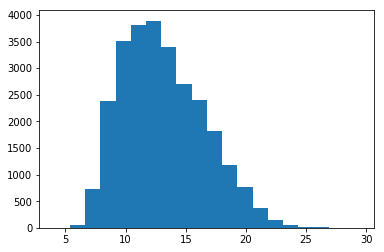

In [17]:
tracts_reduced = tracts_df[['StateAbbr', 'PlaceName', 'MHLTH_CrudePrev', 'PHLTH_CrudePrev', 'SLEEP_CrudePrev',
                            'LPA_CrudePrev', 'OBESITY_CrudePrev', 'CSMOKING_CrudePrev', 'BINGE_CrudePrev',
                            'ACCESS2_CrudePrev','COREW_CrudePrev', 'PlaceFIPS', 'TractFIPS', 'Place_TractID', 'Population2010',
                            'Geolocation']]
tracts_reduced.rename(columns = {
    'StateAbbr': 'state',
    'PlaceName': 'city',
    'PlaceFIPS': 'city_FIPS',
    'TractFIPS': 'tract_FIPS',
    'Place_TractID': 'place_tractID',
    'Population2010': 'population_2010',
    'ACCESS2_CrudePrev': 'PS_lack_health_ins',
    'BINGE_CrudePrev': 'UB_binge_drinking',
    'CSMOKING_CrudePrev': 'UB_current_smoking',
    'LPA_CrudePrev': 'UB_lack_physical_activity',
    'MHLTH_CrudePrev': 'HO_poor_mental_health',
    'OBESITY_CrudePrev': 'UB_obesity',
    'PHLTH_CrudePrev': 'HO_poor_physical_health',
    'SLEEP_CrudePrev': 'UB_less_sleep',
    'Geolocation': 'geolocation'}, inplace = True)
plt.hist(tracts_reduced['HO_poor_mental_health'], bins=20)

In [18]:
tracts_reduced['geo_id'] = tracts_reduced.city_FIPS.apply(
    lambda x: '0' + str(x) if len(str(x)) == 6 else str(x))
len(tracts_reduced)

27210

## Selecting a smaller set of variables from the 2016 American Community Survey (ACS) custom-built dataset

In [19]:
acs16_reduced = acs16_df[['HC01_EST_VC01', 'HC03_EST_VC01', 'HC01_EST_VC04', 'HC01_EST_VC07', 'HC03_EST_VC07',
                          'HC01_EST_VC08', 'HC03_EST_VC08', 'HC01_EST_VC09', 'HC03_EST_VC09', 'HC01_EST_VC10',
                          'HC03_EST_VC10', 'HC01_EST_VC11', 'HC03_EST_VC11', 'HC01_EST_VC12', 'HC03_EST_VC12',
                          'HC01_EST_VC13', 'HC01_EST_VC20', 'HC03_EST_VC20', 'HC01_EST_VC21', 'HC03_EST_VC21',
                          'HC01_EST_VC32', 'HC03_EST_VC32', 'HC01_EST_VC33', 'HC03_EST_VC33',
                          'HC01_EST_VC50', 'HC03_EST_VC50', 'HC01_EST_VC54', 'HC03_EST_VC54', 'HC01_EST_VC55',
                          'HC03_EST_VC55', 'HC01_EST_VC56', 'HC03_EST_VC56', 'HC01_EST_VC57', 'HC03_EST_VC57',
                          'HC01_EST_VC58', 'HC03_EST_VC58', 'HC01_EST_VC74', 'HC03_EST_VC74', 'HC01_EST_VC75',
                          'HC03_EST_VC75', 'HC01_EST_VC76', 'HC03_EST_VC76', 'HC01_EST_VC77', 'HC03_EST_VC77',
                          'HC01_EST_VC78', 'HC03_EST_VC78', 'HC01_EST_VC79', 'HC03_EST_VC79'
                         ]].apply(pd.to_numeric, errors='coerce')
acs16_reduced['geo_id'] = acs16_df['GEO.id2']
acs16_reduced.rename(columns = {
    'HC01_EST_VC01': 'population_CNI',
    'HC03_EST_VC01': 'population_%insured',
    'HC01_EST_VC04': 'age_under18',
    'HC01_EST_VC07': 'age18to64',
    'HC03_EST_VC07': 'age18to64_%insured',
    'HC01_EST_VC08': 'age18to24',
    'HC03_EST_VC08': 'age18to24_%insured',
    'HC01_EST_VC09': 'age25to34',
    'HC03_EST_VC09': 'age25to34_%insured',
    'HC01_EST_VC10': 'age35to44',
    'HC03_EST_VC10': 'age35to44_%insured',
    'HC01_EST_VC11': 'age45to54',
    'HC03_EST_VC11': 'age45to54_%insured',
    'HC01_EST_VC12': 'age55to64',
    'HC03_EST_VC12': 'age55to64_%insured',
    'HC01_EST_VC13': 'age_over64',
    'HC01_EST_VC20': 'male',
    'HC03_EST_VC20': 'male_%insured',
    'HC01_EST_VC21': 'female',
    'HC03_EST_VC21': 'female_%insured',
    'HC01_EST_VC24': 'white',
    'HC03_EST_VC24': 'white_%insured',
    'HC01_EST_VC25': 'blackORaa',
    'HC03_EST_VC25': 'blackORaa_%insured',
    'HC01_EST_VC26': 'amerindian',
    'HC03_EST_VC26': 'amerindian_%insured',
    'HC01_EST_VC27': 'asian',
    'HC03_EST_VC27': 'asian_%insured',
    'HC01_EST_VC28': 'pIslander',
    'HC03_EST_VC28': 'pIslander_%insured',
    'HC01_EST_VC29': 'oRace',
    'HC03_EST_VC29': 'oRace_%insured',
    'HC01_EST_VC30': 'mixRace',
    'HC03_EST_VC30': 'mixRace_%insured',
    'HC01_EST_VC32': 'hispanicAlone',
    'HC03_EST_VC32': 'hispanicAlone_%insured',
    'HC01_EST_VC33': 'whiteAlone',
    'HC03_EST_VC33': 'whiteAlone_%insured',
    'HC01_EST_VC50': 'disability',
    'HC03_EST_VC50': 'disability_%insured',
    'HC01_EST_VC54': 'education_over25',
    'HC03_EST_VC54': 'education_over25_%insured',
    'HC01_EST_VC55': 'over25_lessThanHS',
    'HC03_EST_VC55': 'over25_lessThanHS_%insured',
    'HC01_EST_VC56': 'over25_HS',
    'HC03_EST_VC56': 'over25_HS_%insured',
    'HC01_EST_VC57': 'over25_someCollege',
    'HC03_EST_VC57': 'over25_someCollege_%insured',
    'HC01_EST_VC58': 'over25_college',
    'HC03_EST_VC58': 'over25_college_%insured',
    'HC01_EST_VC74': 'household_income',
    'HC03_EST_VC74': 'household_income_%insured',
    'HC01_EST_VC75': 'household_income_under$25K',
    'HC03_EST_VC75': 'household_income_under$25K_%insured',
    'HC01_EST_VC76': 'household_income_$25to49K',
    'HC03_EST_VC76': 'household_income_$25to49K_%insured',
    'HC01_EST_VC77': 'household_income_$50to74K',
    'HC03_EST_VC77': 'household_income_$50to74K_%insured',
    'HC01_EST_VC78': 'household_income_$75to99K',
    'HC03_EST_VC78': 'household_income_$75to99K_%insured',
    'HC01_EST_VC79': 'household_income_over$99K',
    'HC03_EST_VC79': 'household_income_over$99K_%insured'
}, inplace = True)

In [20]:
#acs16_reduced.dtypes

In [21]:
acs16_reduced['percent_age18to24'] = acs16_reduced.age18to24 / acs16_reduced.age18to64
acs16_reduced['percent_age25to34'] = acs16_reduced.age25to34 / acs16_reduced.age18to64
acs16_reduced['percent_age35to44'] = acs16_reduced.age35to44 / acs16_reduced.age18to64
acs16_reduced['percent_age45to54'] = acs16_reduced.age45to54 / acs16_reduced.age18to64
acs16_reduced['percent_age55to64'] = acs16_reduced.age55to64 / acs16_reduced.age18to64
acs16_reduced['percent_male'] = acs16_reduced.male / acs16_reduced.population_CNI
acs16_reduced['percent_female'] = acs16_reduced.female / acs16_reduced.population_CNI
acs16_reduced['percent_hispanic'] = acs16_reduced.hispanicAlone / acs16_reduced.population_CNI
acs16_reduced['percent_white'] = acs16_reduced.whiteAlone / acs16_reduced.population_CNI
acs16_reduced['percent_disability'] = acs16_reduced.disability / acs16_reduced.population_CNI
acs16_reduced['percent_lessThanHS'] = acs16_reduced.over25_lessThanHS / acs16_reduced.education_over25
acs16_reduced['percent_HS'] = acs16_reduced.over25_HS / acs16_reduced.education_over25
acs16_reduced['percent_someCollege'] = acs16_reduced.over25_someCollege / acs16_reduced.education_over25
acs16_reduced['percent_college'] = acs16_reduced.over25_college / acs16_reduced.education_over25
acs16_reduced['percent_hIncome_under$25K'] = acs16_reduced['household_income_under$25K'] / acs16_reduced.household_income
acs16_reduced['percent_hIncome_$25to49K'] = acs16_reduced['household_income_$25to49K'] / acs16_reduced.household_income
acs16_reduced['percent_hIncome_$50to74K'] = acs16_reduced['household_income_$50to74K'] / acs16_reduced.household_income
acs16_reduced['percent_hIncome_$75to99K'] = acs16_reduced['household_income_$75to99K'] / acs16_reduced.household_income
acs16_reduced['percent_hIncome_over$99K'] = acs16_reduced['household_income_over$99K'] / acs16_reduced.household_income

In [22]:
acs16_final = acs16_reduced[['population_CNI', 'age18to64', 'percent_age18to24', 'percent_age25to34',
                             'percent_age35to44', 'percent_age45to54', 'percent_age55to64', 'percent_male',
                             'percent_female', 'percent_hispanic', 'percent_white', 'percent_disability',
                             'percent_lessThanHS', 'percent_HS', 'percent_someCollege', 'percent_college',
                             'percent_hIncome_under$25K', 'percent_hIncome_$25to49K', 'percent_hIncome_$50to74K',
                             'percent_hIncome_$75to99K', 'percent_hIncome_over$99K',
                             'age18to64_%insured', 'male_%insured', 'female_%insured', 'hispanicAlone_%insured',
                             'whiteAlone_%insured', 'disability_%insured', 'over25_lessThanHS_%insured',
                             'over25_HS_%insured', 'over25_someCollege_%insured', 'over25_college_%insured',
                             'household_income_under$25K_%insured', 'household_income_$25to49K_%insured',
                             'household_income_$50to74K_%insured', 'household_income_$75to99K_%insured',
                             'household_income_over$99K_%insured', 'geo_id']]

## Aggregating by cities

In [23]:
# Grouping by cities
tracts_groups = tracts_reduced.groupby(['geo_id'])

# Calculating mean, median and std for health indicators (HI)
HI_means = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                            ].mean().reset_index()
HI_medians = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                             ].median().reset_index()
HI_stdev = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              ].std().reset_index()

# Calculating counts of tracts per city
tracts_counts = tracts_groups['tract_FIPS'].count().reset_index()

## Merging datasets by geo_id

In [24]:
# Create health indicators (HI) df
HI_df = pd.merge(HI_means, tracts_counts, on='geo_id')
print(f"There are {len(HI_df)} cities represented in the Health Indicators dataset.")
# Create master df
df = pd.merge(HI_df, acs16_final, on='geo_id')
print(f"There are {len(df)} cities represented in our final dataset, after merging with ACS_2016 dataset.")

There are 500 cities represented in the Health Indicators dataset.
There are 495 cities represented in our final dataset, after merging with ACS_2016 dataset.


In [25]:
#df.columns

## Binning by mental health (MH) scores

count    495.000000
mean      12.882364
std        2.110979
min        7.973333
25%       11.396642
50%       12.990789
75%       14.349744
max       18.702564
Name: HO_poor_mental_health, dtype: float64

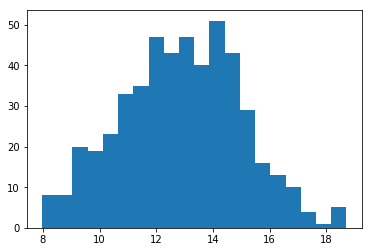

In [26]:
plt.hist(df['HO_poor_mental_health'], bins=20)
df['HO_poor_mental_health'].describe()

In [27]:
# Calculate quantiles on mental health outcome (MH) & prepare bins
bins = [5]
MH_Q1 = int(df['HO_poor_mental_health'].quantile(0.25))
bins.append(MH_Q1)
MH_Q2 = int(df['HO_poor_mental_health'].quantile(0.5))
bins.append(MH_Q2)
MH_Q3 = int(df['HO_poor_mental_health'].quantile(0.75))
bins.append(MH_Q3)
bins.append(20)
print(bins)
labels = ['Q1', 'Q2', 'Q3', 'Q4']
print(labels)

# Append our bins to df
df['quantile_MH'] = pd.cut(df['HO_poor_mental_health'], bins, labels=labels)
df_sorted = df.sort_values('quantile_MH')
df_sorted.head()

[5, 11, 12, 14, 20]
['Q1', 'Q2', 'Q3', 'Q4']


,geo_id,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,tract_FIPS,...,over25_lessThanHS_%insured,over25_HS_%insured,over25_someCollege_%insured,over25_college_%insured,household_income_under$25K_%insured,household_income_$25to49K_%insured,household_income_$50to74K_%insured,household_income_$75to99K_%insured,household_income_over$99K_%insured,quantile_MH
72,0641992,10.636842,9.694737,21.778947,13.305263,14.863158,21.052632,32.621053,7.857895,19,...,76.3,95.7,97.3,98.5,96.3,90.4,95.6,93.4,98.0,Q1
224,1724582,9.377778,8.750000,23.177778,12.211111,17.533333,25.677778,31.005556,8.183333,18,...,79.6,71.4,91.4,98.6,85.9,85.6,94.5,98.8,99.2,Q1
226,1751622,8.566667,8.575000,21.397222,12.272222,16.813889,27.175000,30.211111,6.397222,36,...,80.8,89.7,95.9,97.7,92.8,96.4,96.6,96.6,97.3,Q1
227,1757225,9.673333,9.280000,24.360000,13.820000,18.400000,25.213333,31.000000,9.320000,15,...,57.3,96.8,92.2,97.4,97.2,81.8,84.7,87.7,99.2,Q1
230,1768003,9.356000,9.272000,22.984000,13.628000,19.152000,23.616000,31.528000,8.580000,25,...,75.6,89.0,95.7,97.8,83.1,90.0,90.7,100.0,99.3,Q1


## Exploring differences in various health indicators by mental health (MH) bins

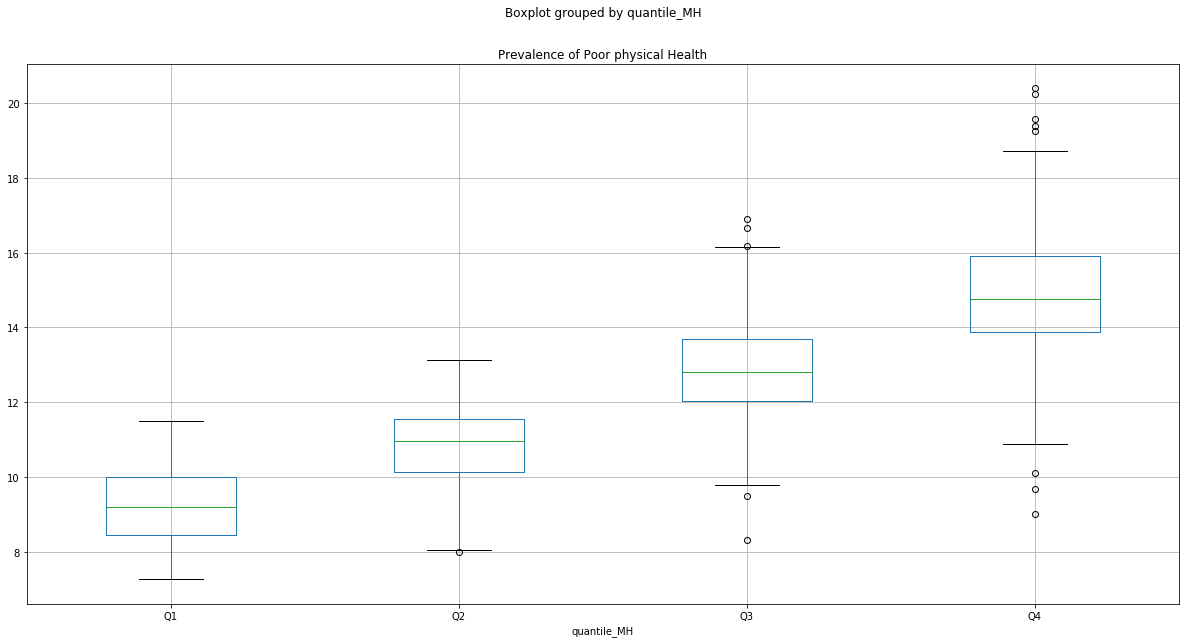

In [69]:
df.boxplot('HO_poor_physical_health', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Poor physical Health")
plt.show()

In [70]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["HO_poor_physical_health"]
group2 = df[df["quantile_MH"] == 'Q2']["HO_poor_physical_health"]
group3 = df[df["quantile_MH"] == 'Q3']["HO_poor_physical_health"]
group4 = df[df["quantile_MH"] == 'Q4']["HO_poor_physical_health"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=332.68181238888224, pvalue=7.469675977082406e-118)

In [71]:
tukey_results_PH = pairwise_tukeyhsd(df_sorted['HO_poor_physical_health'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_PH)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    1.5635  0.9945 2.1325  True 
  Q1     Q3    3.5795  3.098  4.061   True 
  Q1     Q4    5.5872  5.1017 6.0727  True 
  Q2     Q3    2.016   1.5013 2.5307  True 
  Q2     Q4    4.0237  3.5052 4.5422  True 
  Q3     Q4    2.0077  1.5871 2.4282  True 
-------------------------------------------


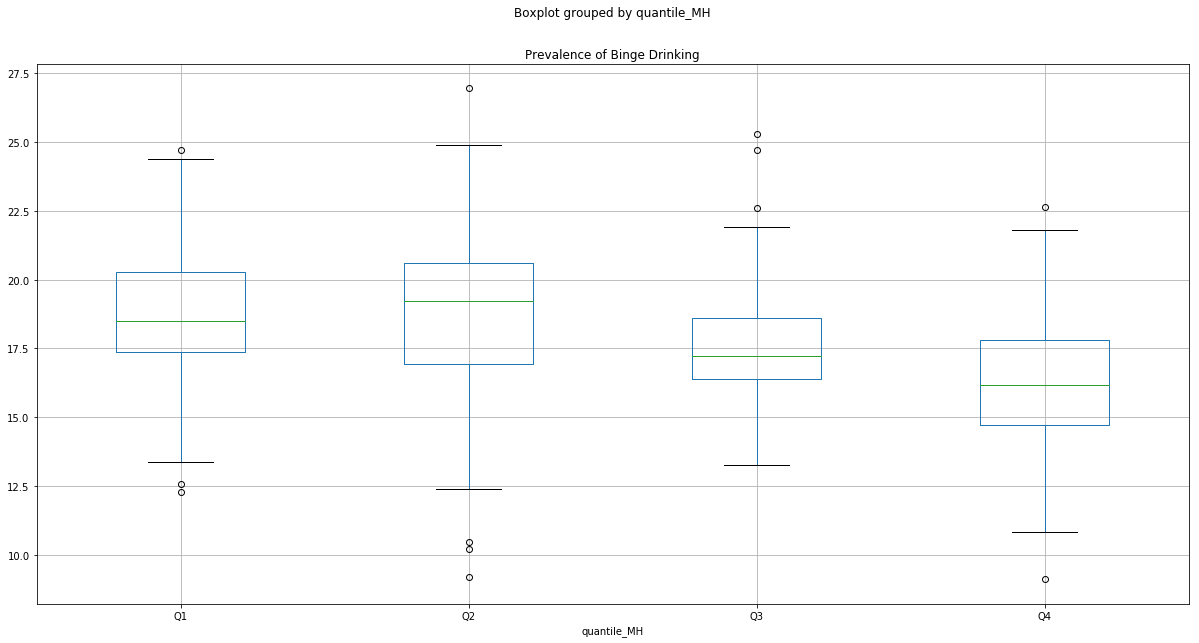

In [72]:
df.boxplot('UB_binge_drinking', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Binge Drinking")
plt.show()

In [73]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_binge_drinking"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_binge_drinking"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_binge_drinking"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_binge_drinking"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=29.577538090538372, pvalue=1.3597656527666888e-17)

In [74]:
tukey_results_UBbd = pairwise_tukeyhsd(df_sorted['UB_binge_drinking'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBbd)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2   -0.1095  -1.0656  0.8467 False 
  Q1     Q3   -1.3137  -2.1228 -0.5046  True 
  Q1     Q4   -2.5816  -3.3975 -1.7658  True 
  Q2     Q3   -1.2043  -2.0692 -0.3393  True 
  Q2     Q4   -2.4722  -3.3434 -1.6009  True 
  Q3     Q4   -1.2679  -1.9746 -0.5612  True 
---------------------------------------------


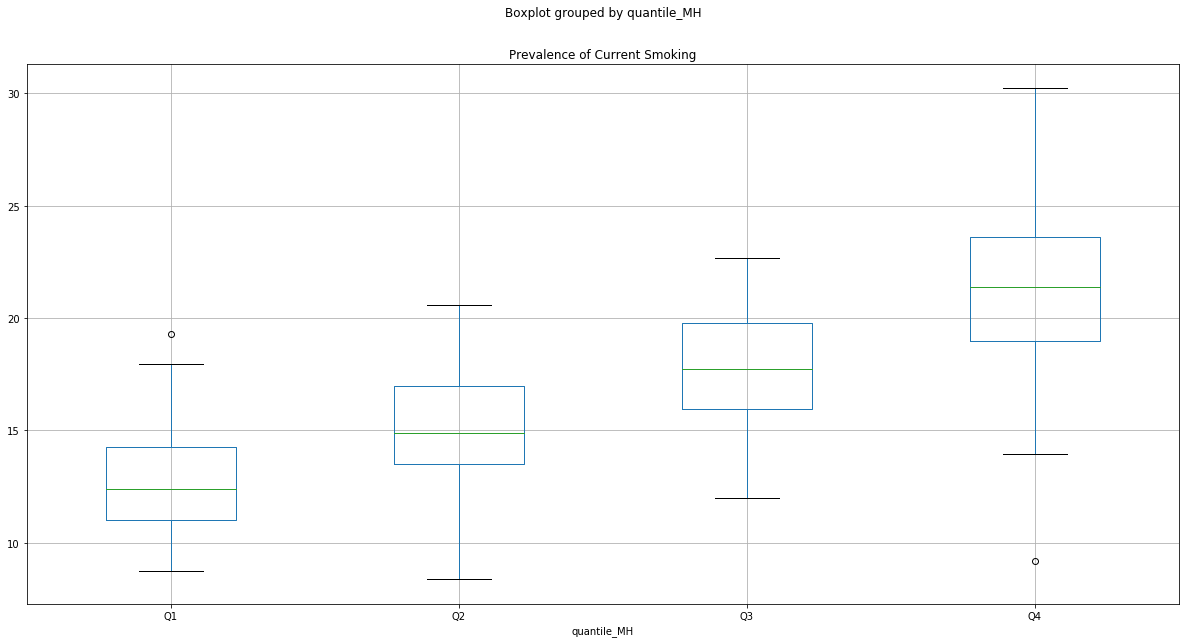

In [75]:
df.boxplot('UB_current_smoking', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Current Smoking")
plt.show()

In [76]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_current_smoking"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_current_smoking"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_current_smoking"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_current_smoking"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=215.62823918363355, pvalue=3.270070067730056e-89)

In [77]:
tukey_results_UBcs = pairwise_tukeyhsd(df_sorted['UB_current_smoking'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBcs)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    2.3138  1.2211 3.4065  True 
  Q1     Q3    5.0864  4.1618 6.011   True 
  Q1     Q4    8.6599  7.7276 9.5922  True 
  Q2     Q3    2.7726  1.7841 3.761   True 
  Q2     Q4    6.3461  5.3505 7.3418  True 
  Q3     Q4    3.5735  2.766  4.3811  True 
-------------------------------------------


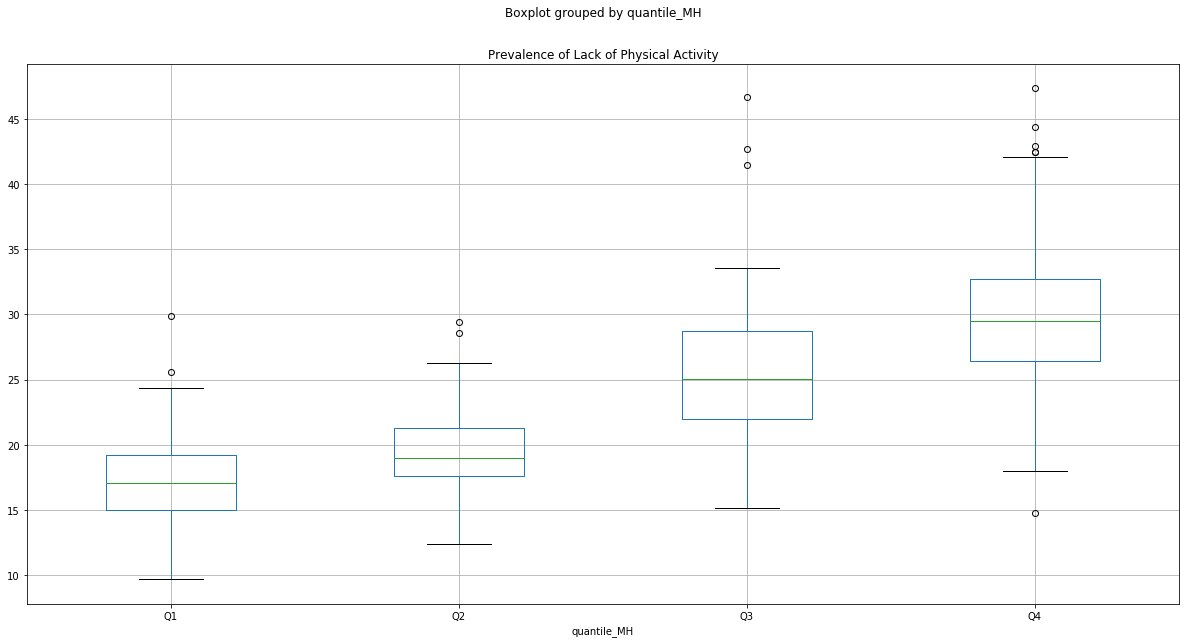

In [78]:
df.boxplot('UB_lack_physical_activity', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Lack of Physical Activity")
plt.show()

In [79]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_lack_physical_activity"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_lack_physical_activity"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_lack_physical_activity"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_lack_physical_activity"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=182.29509278146298, pvalue=2.0213705267808132e-79)

In [80]:
tukey_results_UBpa = pairwise_tukeyhsd(df_sorted['UB_lack_physical_activity'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBpa)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2    2.3603   0.5623  4.1583  True 
  Q1     Q3    8.0785   6.5571  9.5999  True 
  Q1     Q4   12.6273  11.0932 14.1614  True 
  Q2     Q3    5.7182   4.0918  7.3446  True 
  Q2     Q4    10.267   8.6287 11.9053  True 
  Q3     Q4    4.5488    3.22   5.8776  True 
---------------------------------------------


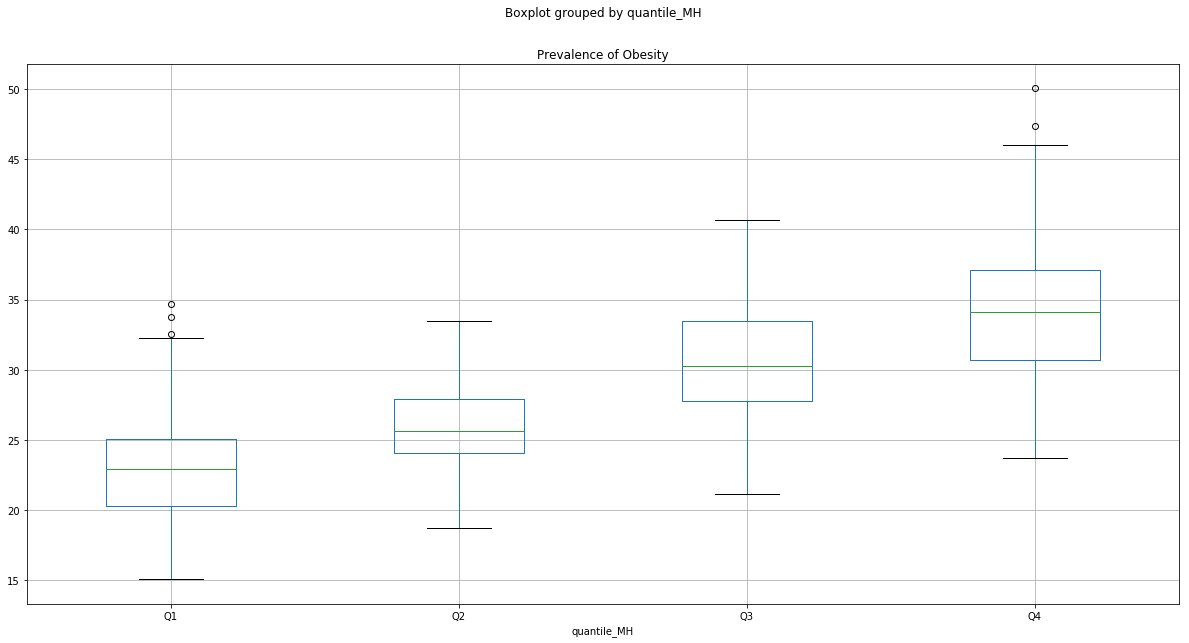

In [81]:
df.boxplot('UB_obesity', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Obesity")
plt.show()

In [82]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_obesity"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_obesity"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_obesity"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_obesity"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=160.45774263762823, pvalue=1.7533558383002598e-72)

In [83]:
tukey_results_UBo = pairwise_tukeyhsd(df_sorted['UB_obesity'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBo)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    3.0415  1.3883 4.6946  True 
  Q1     Q3    7.4072  6.0084 8.806   True 
  Q1     Q4   11.1976  9.7871 12.608  True 
  Q2     Q3    4.3658  2.8704 5.8612  True 
  Q2     Q4    8.1561  6.6498 9.6624  True 
  Q3     Q4    3.7903  2.5686 5.0121  True 
-------------------------------------------


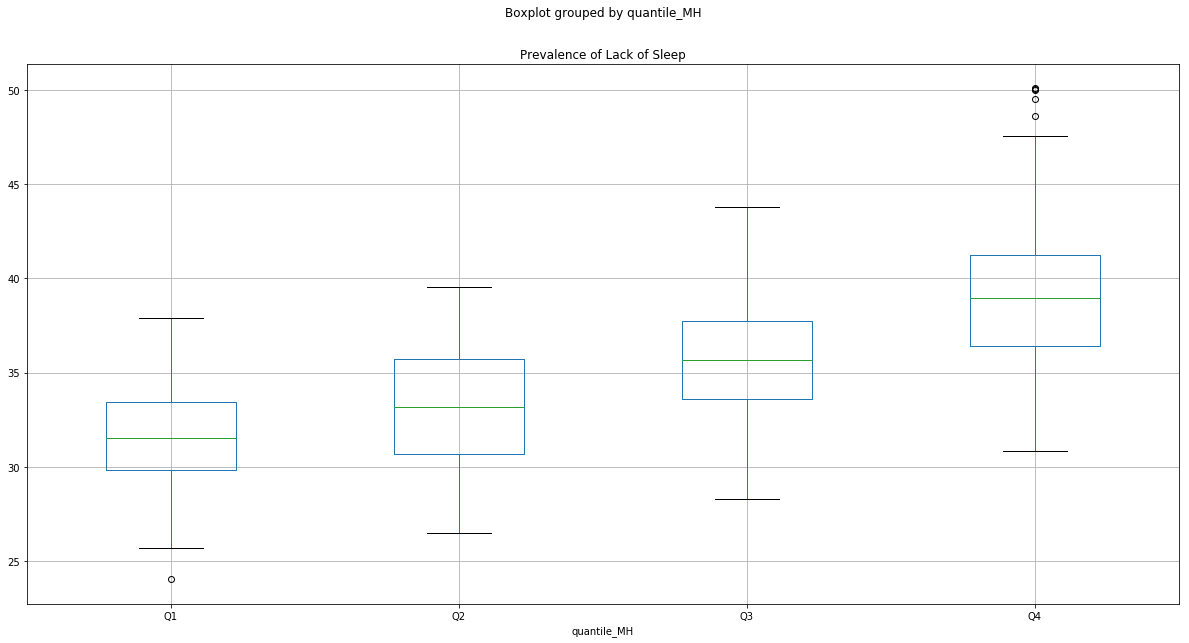

In [84]:
df.boxplot('UB_less_sleep', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Lack of Sleep")
plt.show()

In [85]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_less_sleep"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_less_sleep"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_less_sleep"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_less_sleep"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=120.41557006122659, pvalue=1.8606811638334246e-58)

In [86]:
tukey_results_UBls = pairwise_tukeyhsd(df_sorted['UB_less_sleep'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBls)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    1.5041  0.2098 2.7985  True 
  Q1     Q3    4.1926  3.0974 5.2878  True 
  Q1     Q4    7.5036  6.3993 8.6079  True 
  Q2     Q3    2.6884  1.5176 3.8593  True 
  Q2     Q4    5.9994  4.8201 7.1788  True 
  Q3     Q4    3.311   2.3544 4.2676  True 
-------------------------------------------


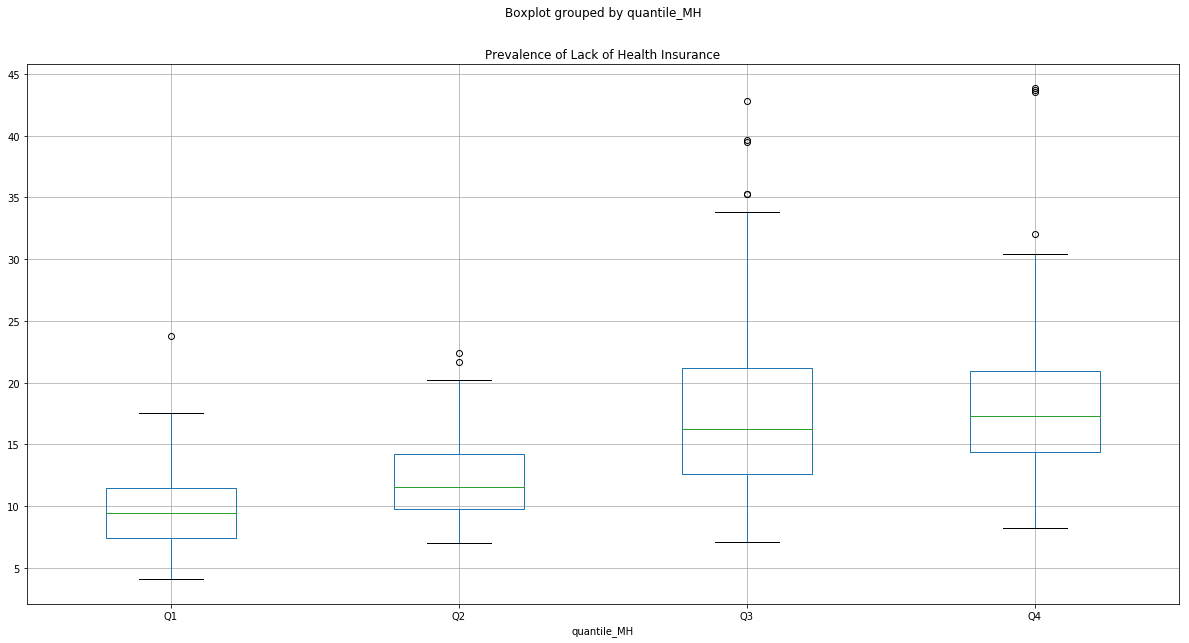

In [87]:
df.boxplot('PS_lack_health_ins', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Lack of Health Insurance")
plt.show()

In [88]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["PS_lack_health_ins"]
group2 = df[df["quantile_MH"] == 'Q2']["PS_lack_health_ins"]
group3 = df[df["quantile_MH"] == 'Q3']["PS_lack_health_ins"]
group4 = df[df["quantile_MH"] == 'Q4']["PS_lack_health_ins"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=70.33063764511444, pvalue=7.50100417350478e-38)

In [89]:
tukey_results_PShi = pairwise_tukeyhsd(df_sorted['PS_lack_health_ins'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_PShi)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2    2.572    0.4757  4.6682  True 
  Q1     Q3    7.7474   5.9736  9.5211  True 
  Q1     Q4    8.7667   6.9781 10.5553  True 
  Q2     Q3    5.1754   3.2792  7.0716  True 
  Q2     Q4    6.1948   4.2847  8.1048  True 
  Q3     Q4    1.0194  -0.5299  2.5687 False 
---------------------------------------------


## Exploring differences in demographic indicators by mental health (MH) bins

In [90]:
#df.columns

F_onewayResult(statistic=2.3587759923186473, pvalue=0.07085459943135472)


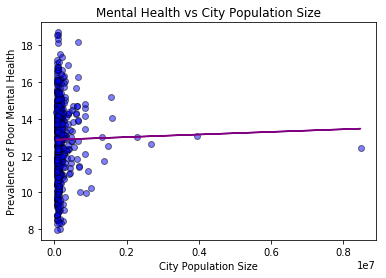

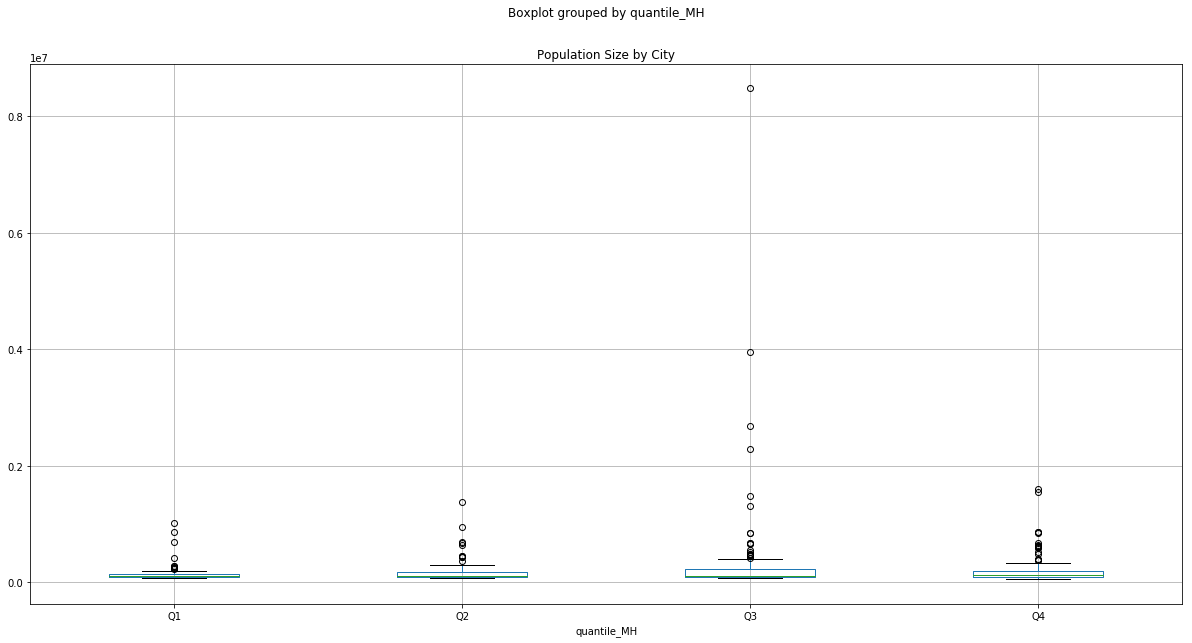

In [91]:
# City population size and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['population_CNI'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs City Population Size")
plt.xlabel("City Population Size")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['population_CNI'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['population_CNI'], p(df['population_CNI']), 'purple')
#plt.show()

# Box plot
df.boxplot('population_CNI', by='quantile_MH', figsize=(20, 10))
plt.title("Population Size by City")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["population_CNI"]
group2 = df[df["quantile_MH"] == 'Q2']["population_CNI"]
group3 = df[df["quantile_MH"] == 'Q3']["population_CNI"]
group4 = df[df["quantile_MH"] == 'Q4']["population_CNI"]
print(stats.f_oneway(group1, group2, group3, group4))

F_onewayResult(statistic=2.267930135739863, pvalue=0.07981448777003665)
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1 group2   meandiff     lower        upper    reject
---------------------------------------------------------
  Q1     Q2    30175.3898 -92256.2259  152607.0055 False 
  Q1     Q3    96193.5057  -7402.6559  199789.6672 False 
  Q1     Q4    31550.4324 -72909.2627  136010.1275 False 
  Q2     Q3    66018.1159 -44730.1654  176766.3971 False 
  Q2     Q4    1375.0426  -110181.4229 112931.5081 False 
  Q3     Q4   -64643.0733 -155127.9293  25841.7828 False 
---------------------------------------------------------


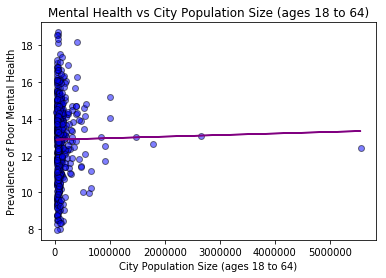

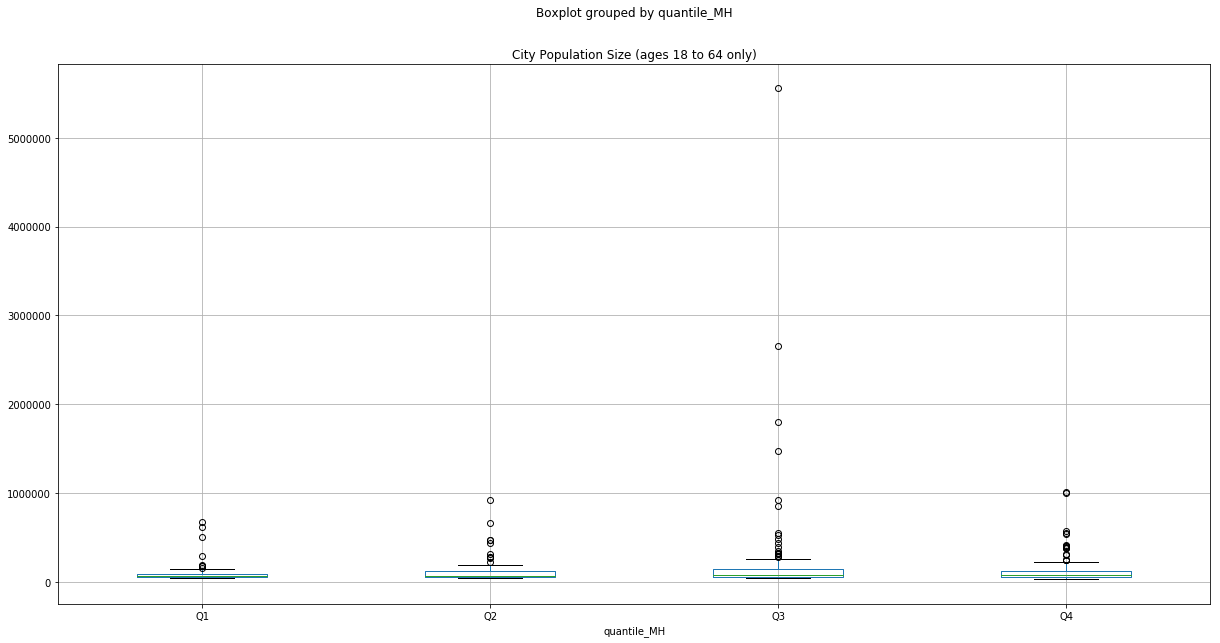

In [92]:
# City population size (ages 18 to 64) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['age18to64'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs City Population Size (ages 18 to 64)")
plt.xlabel("City Population Size (ages 18 to 64)")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['age18to64'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['age18to64'], p(df['age18to64']), 'purple')
#plt.show()

# Box plot
df.boxplot('age18to64', by='quantile_MH', figsize=(20, 10))
plt.title("City Population Size (ages 18 to 64 only)")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["age18to64"]
group2 = df[df["quantile_MH"] == 'Q2']["age18to64"]
group3 = df[df["quantile_MH"] == 'Q3']["age18to64"]
group4 = df[df["quantile_MH"] == 'Q4']["age18to64"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['age18to64'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=18.412045874889493, pvalue=2.464934298224931e-11)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    0.0338   0.0092 0.0585  True 
  Q1     Q3    0.0367   0.0158 0.0576  True 
  Q1     Q4    0.0606   0.0396 0.0817  True 
  Q2     Q3    0.0029  -0.0194 0.0252 False 
  Q2     Q4    0.0268   0.0043 0.0493  True 
  Q3     Q4    0.0239   0.0056 0.0421  True 
--------------------------------------------


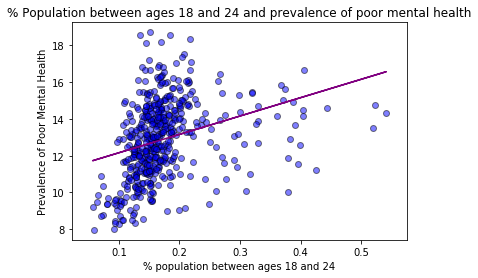

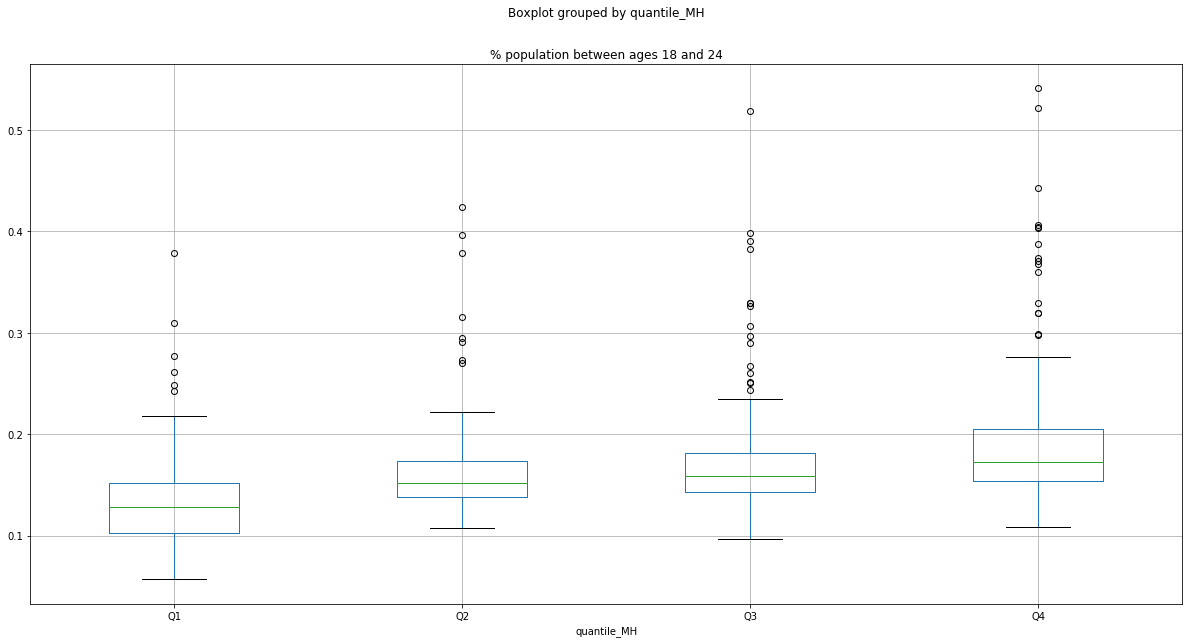

In [93]:
# % population between ages 18 and 24 and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_age18to24'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% Population between ages 18 and 24 and prevalence of poor mental health")
plt.xlabel("% population between ages 18 and 24")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_age18to24'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_age18to24'], p(df['percent_age18to24']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_age18to24', by='quantile_MH', figsize=(20, 10))
plt.title("% population between ages 18 and 24")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_age18to24"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_age18to24"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_age18to24"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_age18to24"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_age18to24'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=3.4454089516060487, pvalue=0.016637601311991875)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    0.0147   0.0007 0.0286  True 
  Q1     Q3    0.0124   0.0005 0.0242  True 
  Q1     Q4    0.0124   0.0005 0.0243  True 
  Q2     Q3   -0.0023  -0.0149 0.0103 False 
  Q2     Q4   -0.0023   -0.015 0.0105 False 
  Q3     Q4    0.0001  -0.0103 0.0104 False 
--------------------------------------------


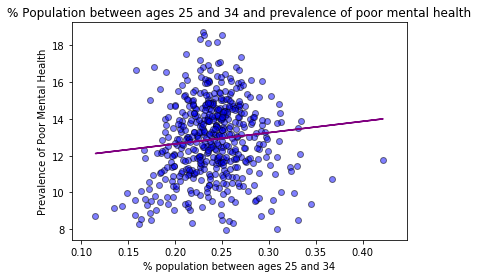

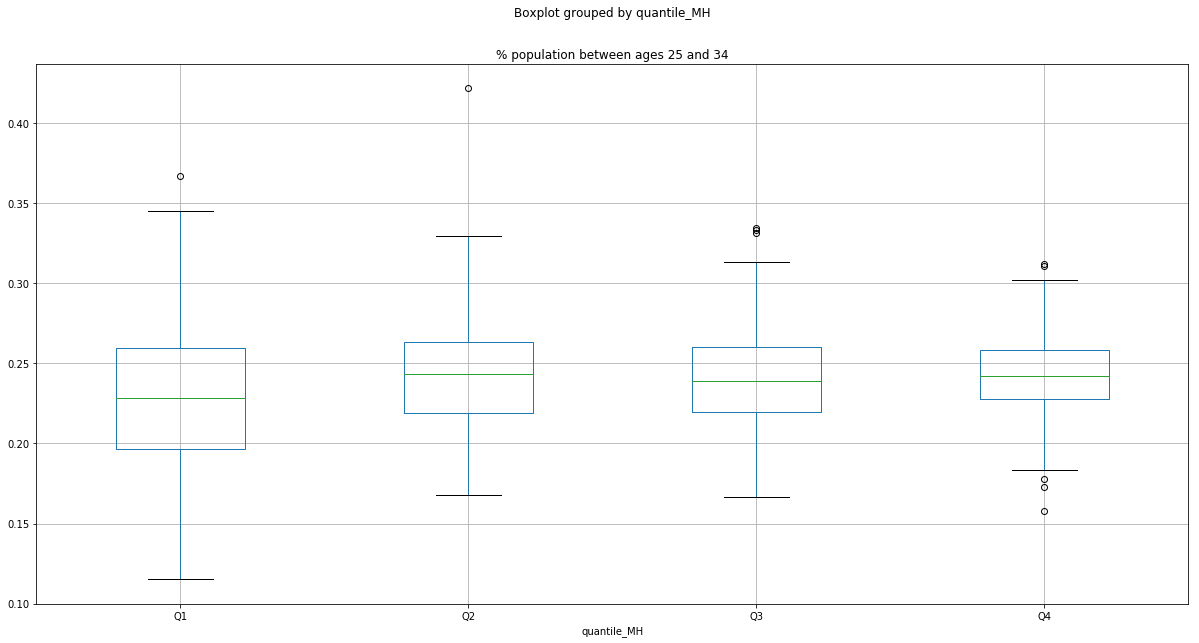

In [94]:
# % population between ages 25 and 34 and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_age25to34'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% Population between ages 25 and 34 and prevalence of poor mental health")
plt.xlabel("% population between ages 25 and 34")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_age25to34'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_age25to34'], p(df['percent_age25to34']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_age25to34', by='quantile_MH', figsize=(20, 10))
plt.title("% population between ages 25 and 34")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_age25to34"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_age25to34"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_age25to34"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_age25to34"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_age25to34'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=13.215862155333866, pvalue=2.60591692325719e-08)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2    -0.013  -0.0243 -0.0016  True 
  Q1     Q3   -0.0182  -0.0278 -0.0086  True 
  Q1     Q4   -0.0228  -0.0325 -0.0131  True 
  Q2     Q3   -0.0053  -0.0155  0.005  False 
  Q2     Q4   -0.0099  -0.0202  0.0005 False 
  Q3     Q4   -0.0046   -0.013  0.0038 False 
---------------------------------------------


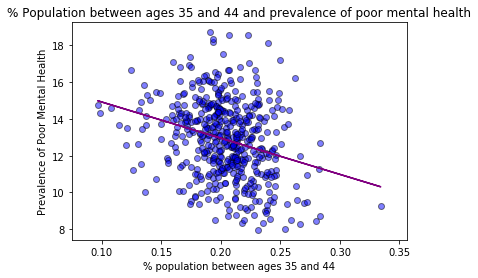

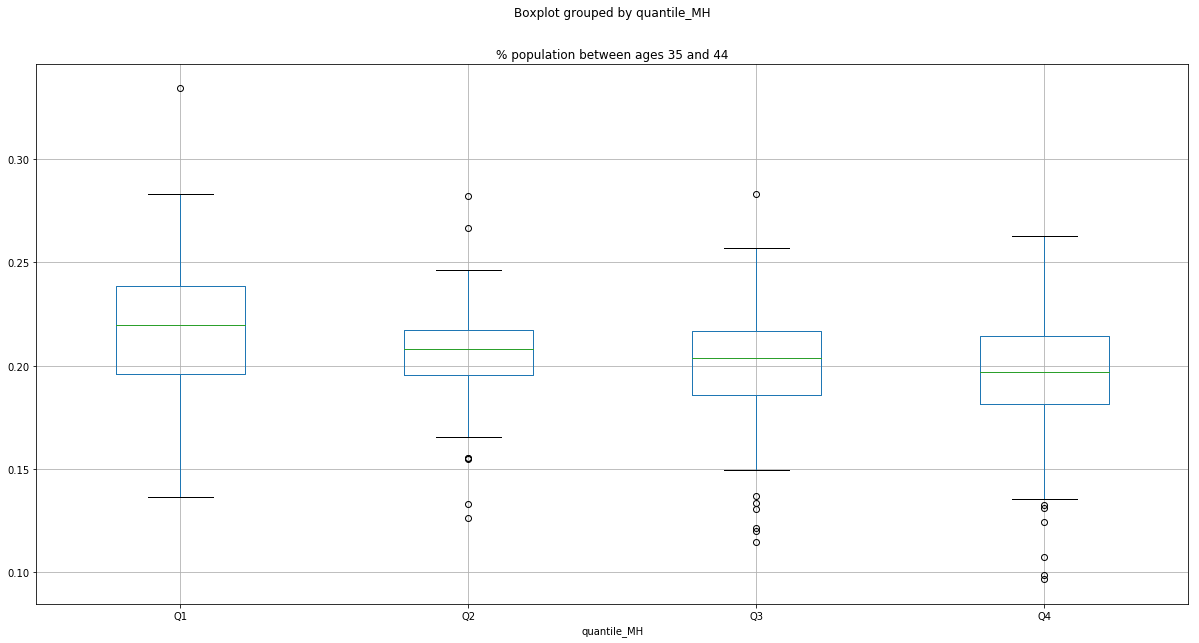

In [95]:
# % population between ages 35 and 44 and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_age35to44'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% Population between ages 35 and 44 and prevalence of poor mental health")
plt.xlabel("% population between ages 35 and 44")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_age35to44'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_age35to44'], p(df['percent_age35to44']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_age35to44', by='quantile_MH', figsize=(20, 10))
plt.title("% population between ages 35 and 44")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_age35to44"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_age35to44"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_age35to44"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_age35to44"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_age35to44'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=23.708474289017378, pvalue=2.407946471796725e-14)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2   -0.0228  -0.0354 -0.0102  True 
  Q1     Q3   -0.0226  -0.0333  -0.012  True 
  Q1     Q4   -0.0352  -0.0459 -0.0244  True 
  Q2     Q3    0.0002  -0.0112  0.0116 False 
  Q2     Q4   -0.0123  -0.0238 -0.0008  True 
  Q3     Q4   -0.0125  -0.0219 -0.0032  True 
---------------------------------------------


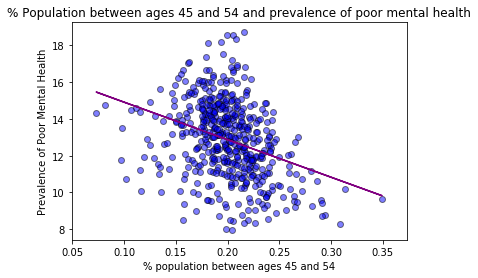

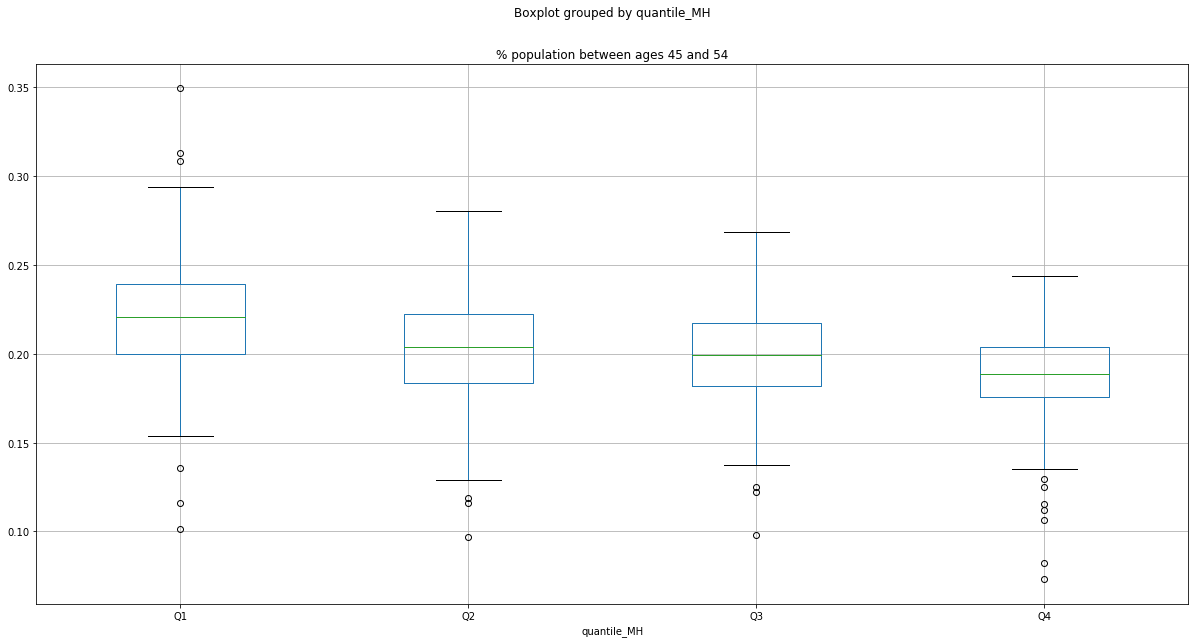

In [96]:
# % population between ages 45 and 54 and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_age45to54'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% Population between ages 45 and 54 and prevalence of poor mental health")
plt.xlabel("% population between ages 45 and 54")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_age45to54'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_age45to54'], p(df['percent_age45to54']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_age45to54', by='quantile_MH', figsize=(20, 10))
plt.title("% population between ages 45 and 54")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_age45to54"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_age45to54"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_age45to54"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_age45to54"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_age45to54'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=4.379106209382511, pvalue=0.0046848579919974796)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2   -0.0127  -0.0258  0.0003 False 
  Q1     Q3   -0.0082  -0.0193  0.0028 False 
  Q1     Q4   -0.0151  -0.0262 -0.0039  True 
  Q2     Q3    0.0045  -0.0073  0.0163 False 
  Q2     Q4   -0.0023  -0.0142  0.0096 False 
  Q3     Q4   -0.0068  -0.0165  0.0028 False 
---------------------------------------------


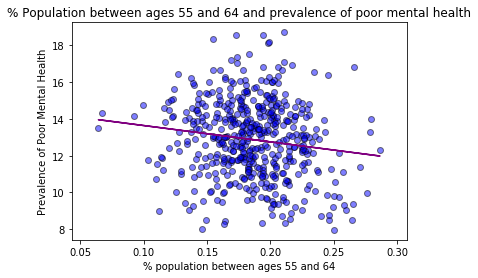

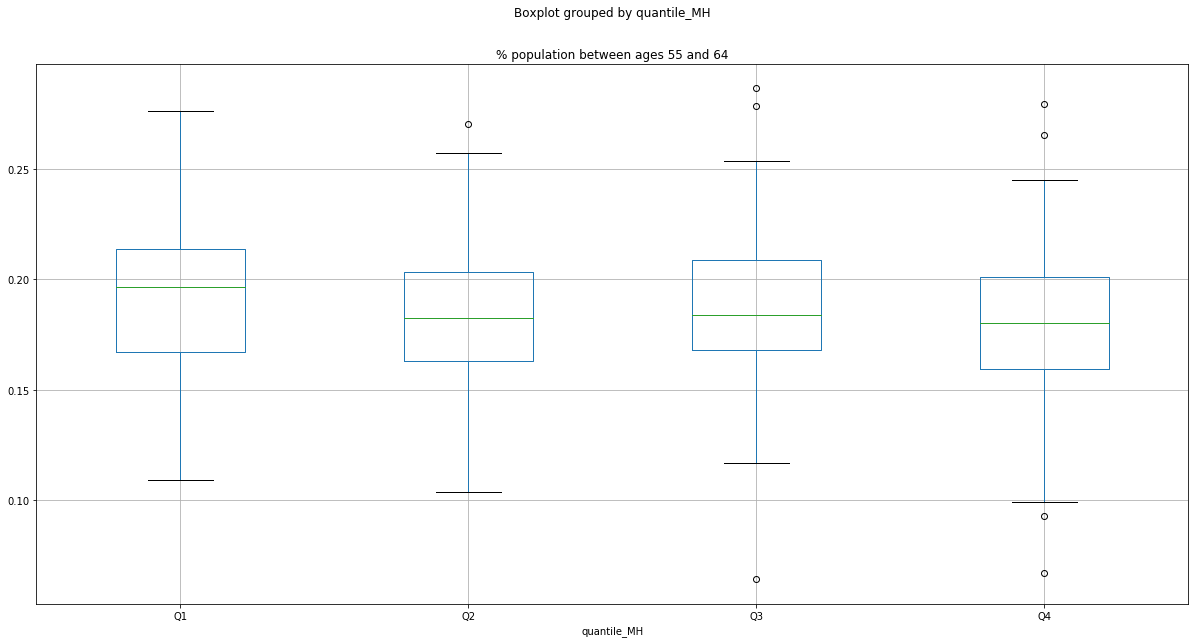

In [97]:
# % population between ages 55 and 64 and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_age55to64'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% Population between ages 55 and 64 and prevalence of poor mental health")
plt.xlabel("% population between ages 55 and 64")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_age55to64'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_age55to64'], p(df['percent_age55to64']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_age55to64', by='quantile_MH', figsize=(20, 10))
plt.title("% population between ages 55 and 64")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_age55to64"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_age55to64"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_age55to64"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_age55to64"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_age55to64'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=9.709969294114439, pvalue=3.1007285156938013e-06)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    0.0029  -0.0032 0.009  False 
  Q1     Q3    0.0051  -0.0001 0.0103 False 
  Q1     Q4    0.0103   0.0051 0.0155  True 
  Q2     Q3    0.0022  -0.0033 0.0078 False 
  Q2     Q4    0.0075   0.0019 0.013   True 
  Q3     Q4    0.0052   0.0007 0.0097  True 
--------------------------------------------


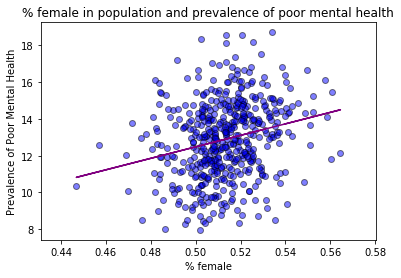

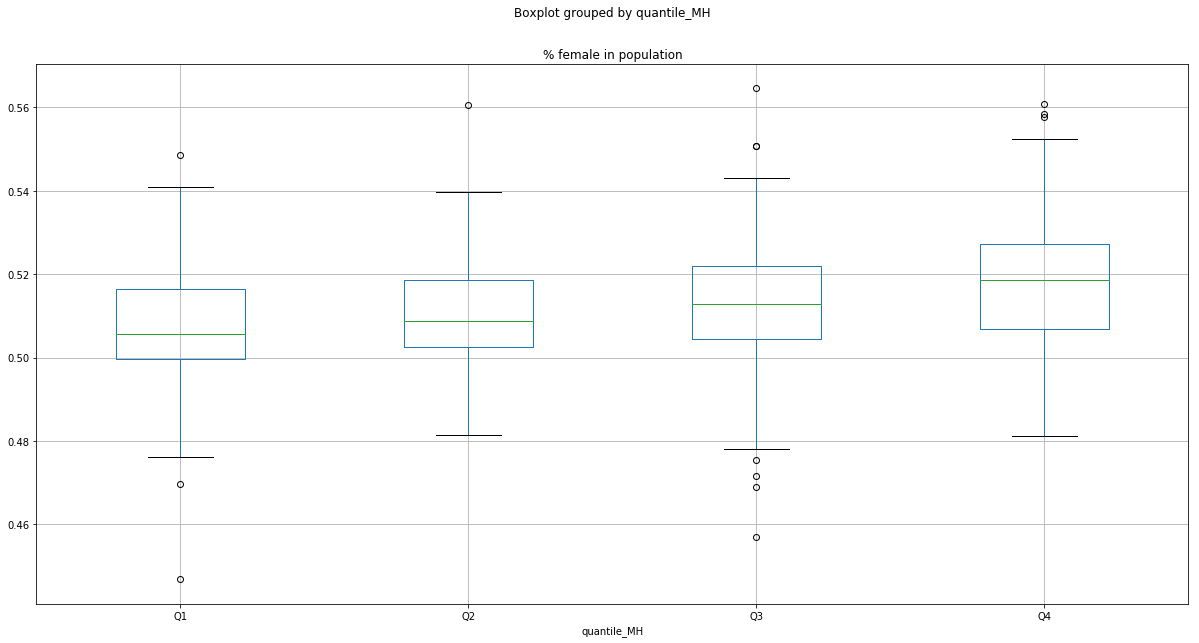

In [98]:
# % female and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_female'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% female in population and prevalence of poor mental health")
plt.xlabel("% female")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_female'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_female'], p(df['percent_female']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_female', by='quantile_MH', figsize=(20, 10))
plt.title("% female in population")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_female"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_female"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_female"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_female"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_female'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

In [99]:
df.columns

Index(['geo_id', 'HO_poor_mental_health', 'HO_poor_physical_health',
       'UB_binge_drinking', 'UB_current_smoking', 'UB_lack_physical_activity',
       'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins', 'tract_FIPS',
       'population_CNI', 'age18to64', 'percent_age18to24', 'percent_age25to34',
       'percent_age35to44', 'percent_age45to54', 'percent_age55to64',
       'percent_male', 'percent_female', 'percent_hispanic', 'percent_white',
       'percent_disability', 'percent_lessThanHS', 'percent_HS',
       'percent_someCollege', 'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_$25to49K', 'percent_hIncome_$50to74K',
       'percent_hIncome_$75to99K', 'percent_hIncome_over$99K',
       'age18to64_%insured', 'male_%insured', 'female_%insured',
       'hispanicAlone_%insured', 'whiteAlone_%insured', 'disability_%insured',
       'over25_lessThanHS_%insured', 'over25_HS_%insured',
       'over25_someCollege_%insured', 'over25_college_%insured',
       'house

F_onewayResult(statistic=62.0435152036847, pvalue=5.017093431645902e-34)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    0.0309  0.0046 0.0572  True 
  Q1     Q3    0.0748  0.0526 0.0971  True 
  Q1     Q4    0.1108  0.0883 0.1332  True 
  Q2     Q3    0.0439  0.0201 0.0677  True 
  Q2     Q4    0.0798  0.0559 0.1038  True 
  Q3     Q4    0.036   0.0165 0.0554  True 
-------------------------------------------


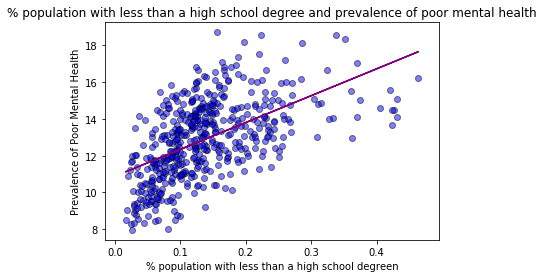

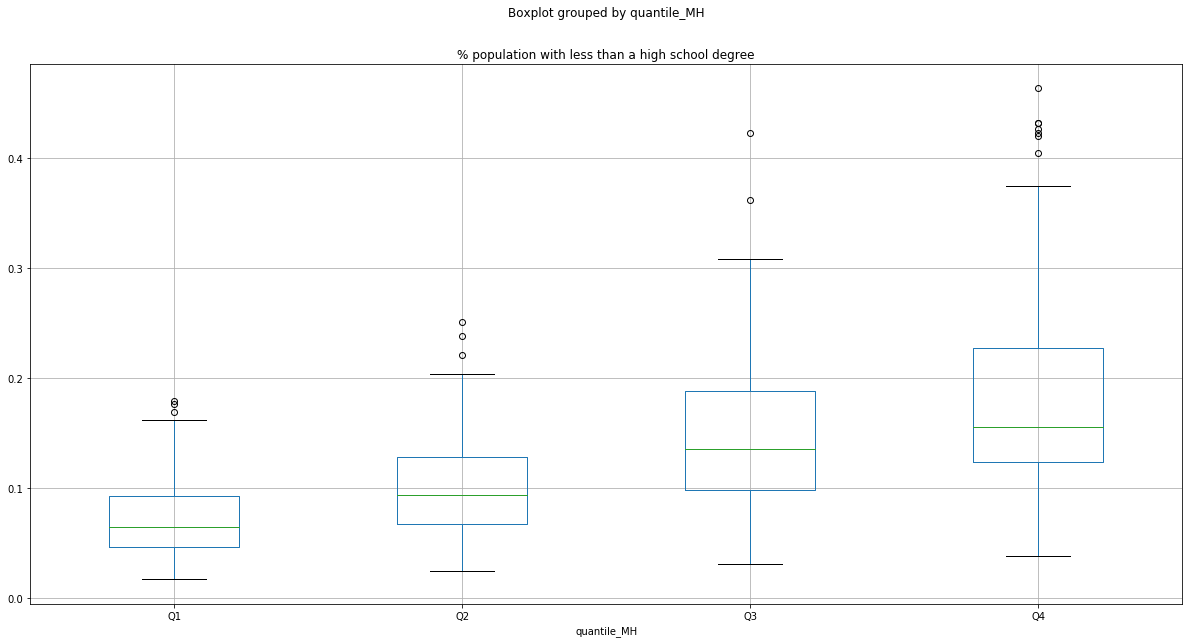

In [100]:
# Educational attainment (less than a high school degree) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_lessThanHS'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with less than a high school degree and prevalence of poor mental health")
plt.xlabel("% population with less than a high school degreen")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_lessThanHS'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_lessThanHS'], p(df['percent_lessThanHS']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_lessThanHS', by='quantile_MH', figsize=(20, 10))
plt.title("% population with less than a high school degree")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_lessThanHS"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_lessThanHS"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_lessThanHS"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_lessThanHS"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_lessThanHS'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=141.13447438136762, pvalue=6.069254531717285e-66)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    0.0551  0.0344 0.0757  True 
  Q1     Q3    0.1014  0.084  0.1189  True 
  Q1     Q4    0.1333  0.1157 0.1509  True 
  Q2     Q3    0.0464  0.0277 0.065   True 
  Q2     Q4    0.0782  0.0595 0.097   True 
  Q3     Q4    0.0319  0.0167 0.0471  True 
-------------------------------------------


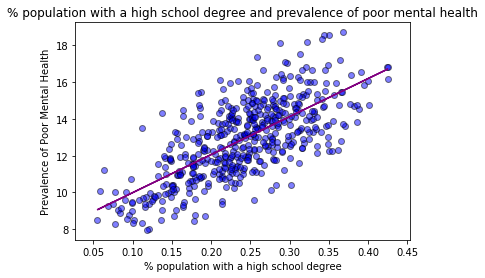

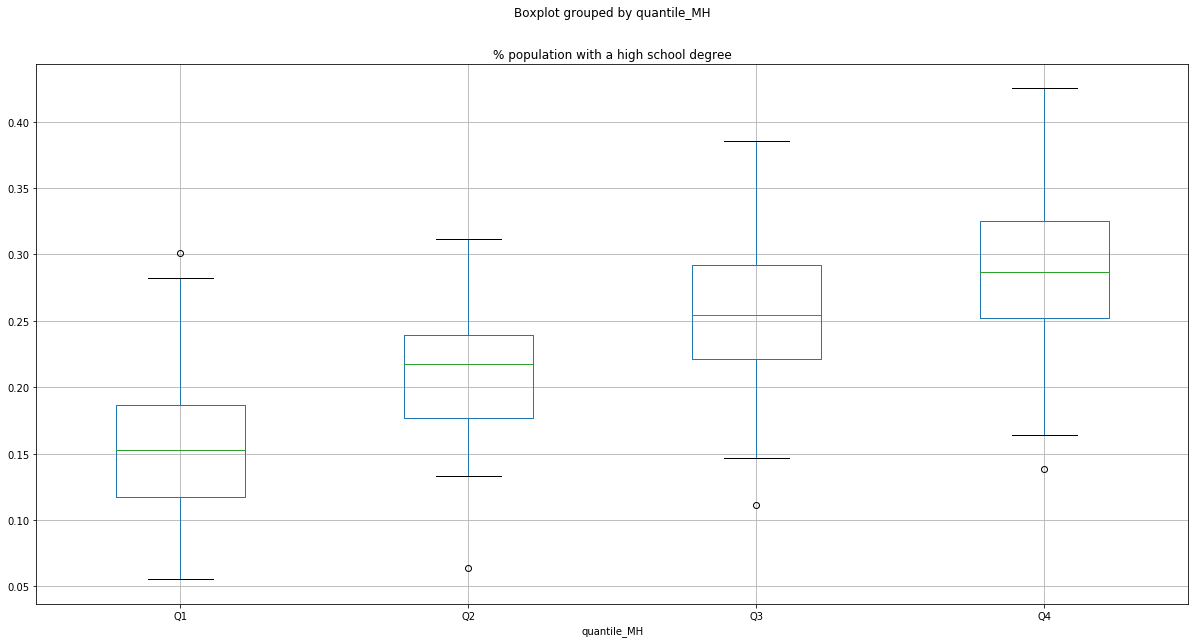

In [101]:
# Educational attainment (high school degree) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_HS'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with a high school degree and prevalence of poor mental health")
plt.xlabel("% population with a high school degree")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_HS'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_HS'], p(df['percent_HS']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_HS', by='quantile_MH', figsize=(20, 10))
plt.title("% population with a high school degree")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_HS"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_HS"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_HS"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_HS"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_HS'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=18.962723729727138, pvalue=1.1894895096493432e-11)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    0.0488   0.0264 0.0712  True 
  Q1     Q3    0.053    0.034  0.0719  True 
  Q1     Q4    0.0408   0.0216 0.0599  True 
  Q2     Q3    0.0042  -0.0161 0.0244 False 
  Q2     Q4   -0.0081  -0.0285 0.0124 False 
  Q3     Q4   -0.0122  -0.0288 0.0043 False 
--------------------------------------------


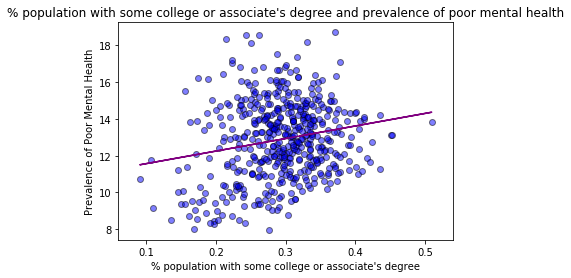

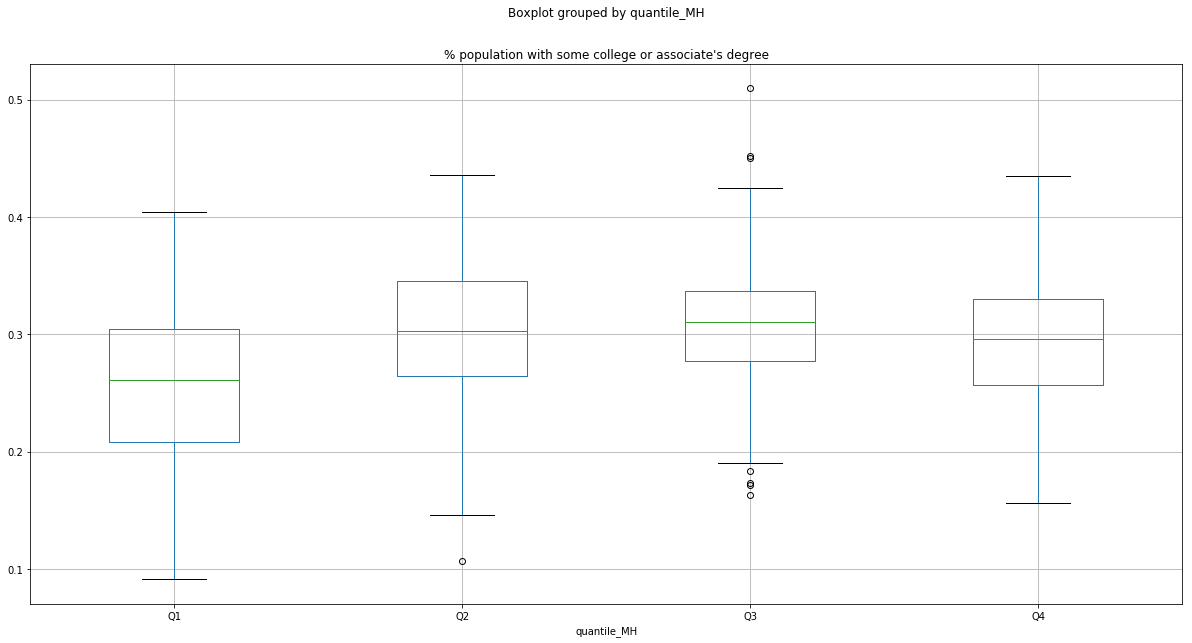

In [102]:
# Educational attainment (some college or associate's degree) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_someCollege'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with some college or associate's degree and prevalence of poor mental health")
plt.xlabel("% population with some college or associate's degree")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_someCollege'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_someCollege'], p(df['percent_someCollege']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_someCollege', by='quantile_MH', figsize=(20, 10))
plt.title("% population with some college or associate's degree")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_someCollege"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_someCollege"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_someCollege"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_someCollege"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_someCollege'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=177.9288041971952, pvalue=4.542921352179584e-78)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2   -0.1348  -0.1741 -0.0955  True 
  Q1     Q3   -0.2292  -0.2624  -0.196  True 
  Q1     Q4   -0.2848  -0.3183 -0.2513  True 
  Q2     Q3   -0.0944  -0.1299 -0.0589  True 
  Q2     Q4    -0.15   -0.1858 -0.1143  True 
  Q3     Q4   -0.0556  -0.0846 -0.0266  True 
---------------------------------------------


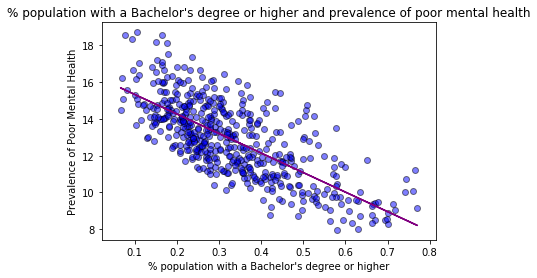

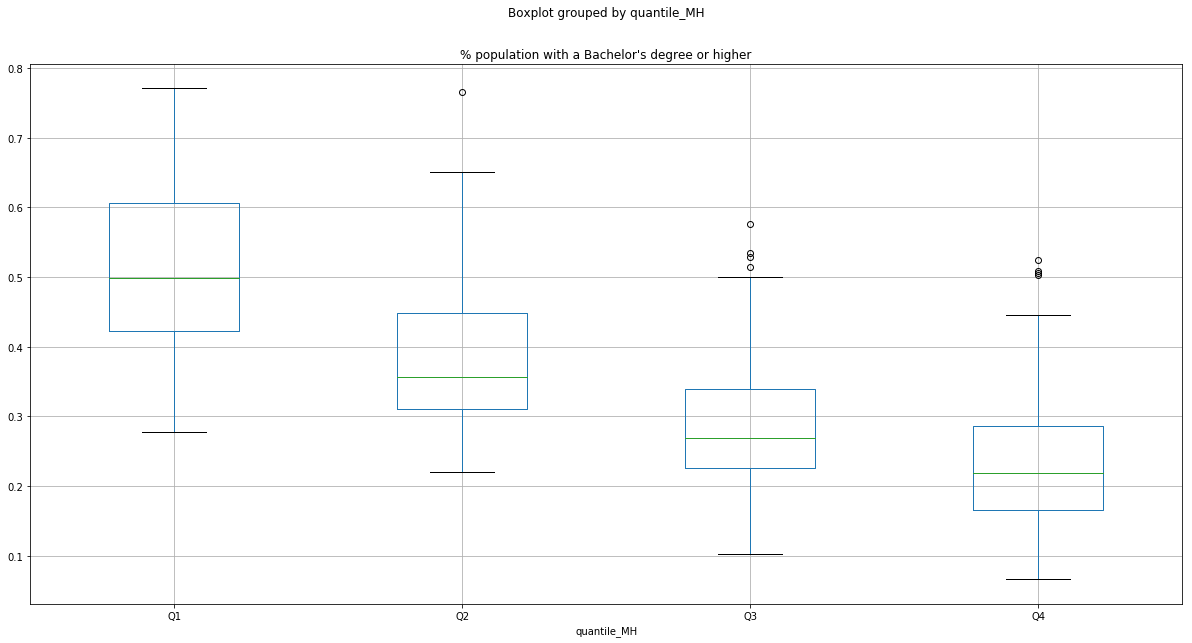

In [103]:
# Educational attainment (Bachelor's degree or higher) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_college'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with a Bachelor's degree or higher and prevalence of poor mental health")
plt.xlabel("% population with a Bachelor's degree or higher")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_college'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_college'], p(df['percent_college']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_college', by='quantile_MH', figsize=(20, 10))
plt.title("% population with a Bachelor's degree or higher")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_college"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_college"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_college"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_college"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_college'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=163.22702167025164, pvalue=2.1809742567795443e-73)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    0.0398  0.0178 0.0617  True 
  Q1     Q3    0.0903  0.0717 0.1089  True 
  Q1     Q4    0.1511  0.1324 0.1698  True 
  Q2     Q3    0.0506  0.0307 0.0704  True 
  Q2     Q4    0.1113  0.0913 0.1314  True 
  Q3     Q4    0.0608  0.0445 0.077   True 
-------------------------------------------


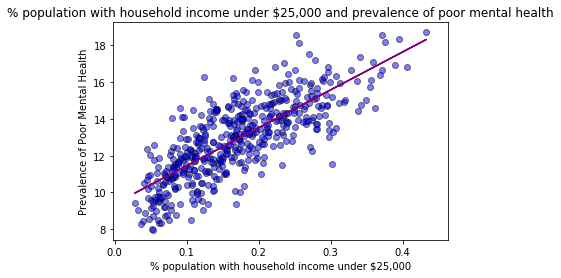

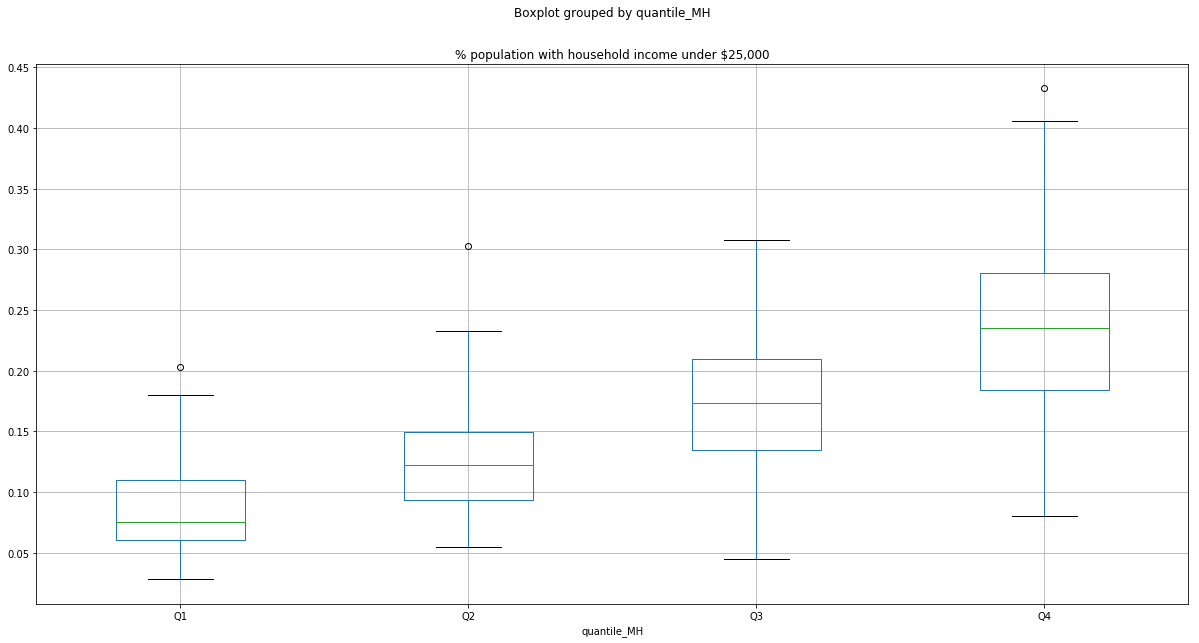

In [104]:
# Household income (under $25,000) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_hIncome_under$25K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income under $25,000 and prevalence of poor mental health")
plt.xlabel("% population with household income under $25,000")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_under$25K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_under$25K'], p(df['percent_hIncome_under$25K']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_hIncome_under$25K', by='quantile_MH', figsize=(20, 10))
plt.title("% population with household income under $25,000")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_hIncome_under$25K"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_hIncome_under$25K"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_hIncome_under$25K"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_hIncome_under$25K"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_hIncome_under$25K'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=193.84086296598716, pvalue=6.481695610634023e-83)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    0.0492  0.033  0.0653  True 
  Q1     Q3    0.0931  0.0794 0.1067  True 
  Q1     Q4    0.1221  0.1083 0.1359  True 
  Q2     Q3    0.0439  0.0293 0.0585  True 
  Q2     Q4    0.0729  0.0582 0.0876  True 
  Q3     Q4    0.029   0.0171 0.0409  True 
-------------------------------------------


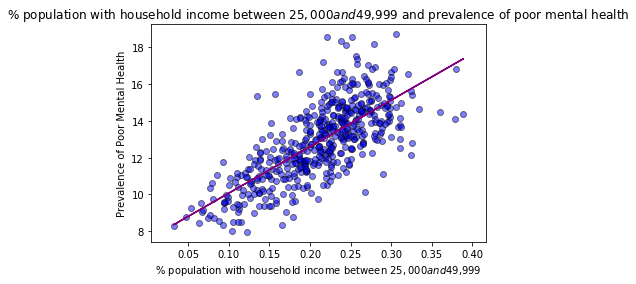

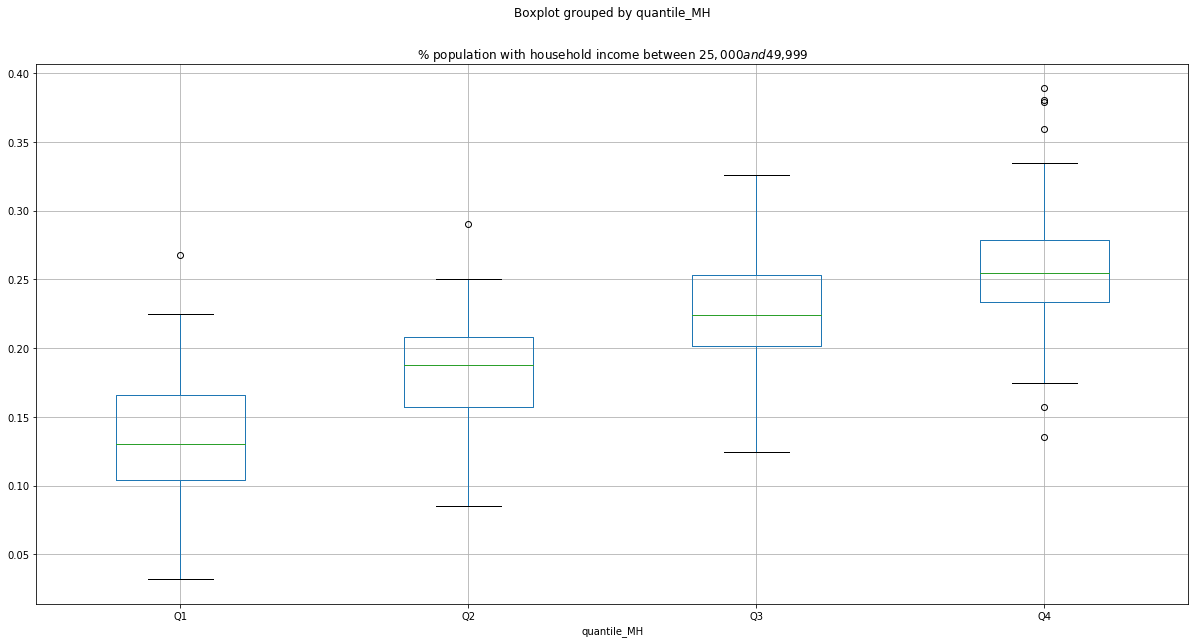

In [105]:
# Household income ($25,000-$49,999) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_hIncome_$25to49K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income between $25,000 and $49,999 and prevalence of poor mental health")
plt.xlabel("% population with household income between $25,000 and $49,999")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_$25to49K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_$25to49K'], p(df['percent_hIncome_$25to49K']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_hIncome_$25to49K', by='quantile_MH', figsize=(20, 10))
plt.title("% population with household income between $25,000 and $49,999")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_hIncome_$25to49K"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_hIncome_$25to49K"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_hIncome_$25to49K"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_hIncome_$25to49K"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_hIncome_$25to49K'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=69.84819169225055, pvalue=1.2420440960283964e-37)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    0.0418   0.0295 0.0541  True 
  Q1     Q3    0.0531   0.0427 0.0635  True 
  Q1     Q4    0.0523   0.0419 0.0628  True 
  Q2     Q3    0.0114   0.0002 0.0225  True 
  Q2     Q4    0.0106  -0.0006 0.0218 False 
  Q3     Q4   -0.0008  -0.0099 0.0083 False 
--------------------------------------------


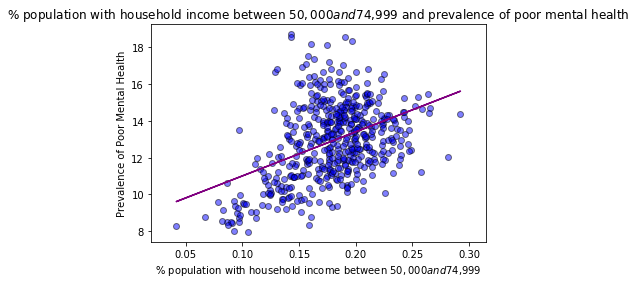

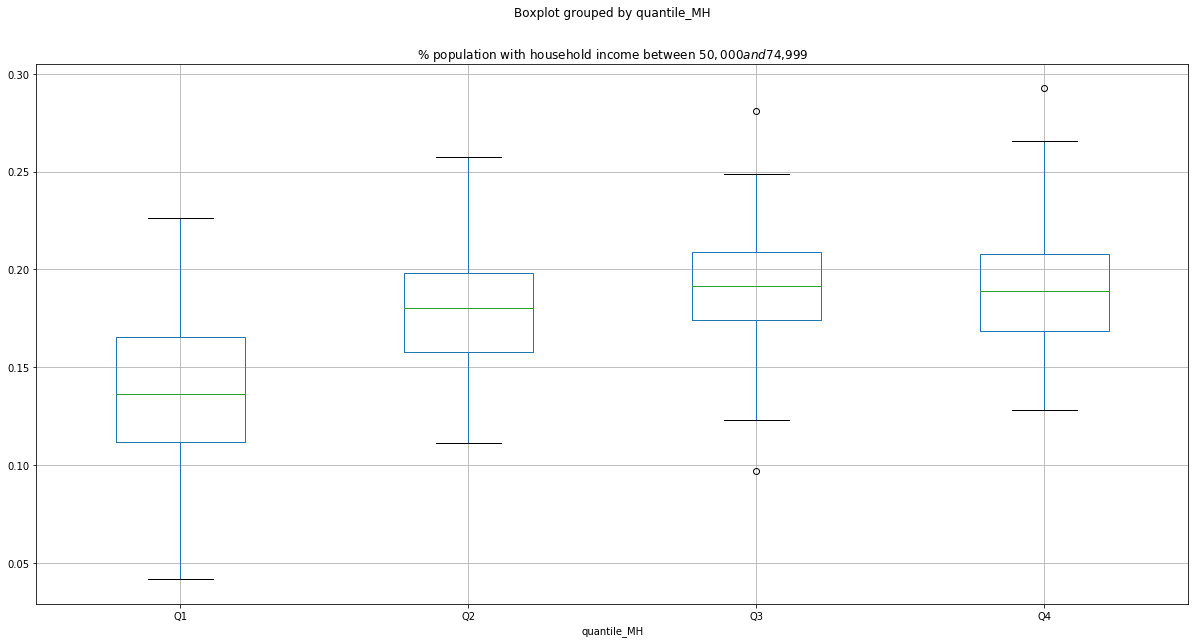

In [106]:
# Household income ($50,000-$74,999) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_hIncome_$50to74K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income between $50,000 and $74,999 and prevalence of poor mental health")
plt.xlabel("% population with household income between $50,000 and $74,999")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_$50to74K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_$50to74K'], p(df['percent_hIncome_$50to74K']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_hIncome_$50to74K', by='quantile_MH', figsize=(20, 10))
plt.title("% population with household income between $50,000 and $74,999")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_hIncome_$50to74K"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_hIncome_$50to74K"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_hIncome_$50to74K"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_hIncome_$50to74K"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_hIncome_$50to74K'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=13.959936696556735, pvalue=9.524360277240025e-09)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2    0.0144   0.0032  0.0255  True 
  Q1     Q3    0.0114   0.002   0.0209  True 
  Q1     Q4   -0.0059  -0.0154  0.0036 False 
  Q2     Q3    -0.003  -0.0131  0.0071 False 
  Q2     Q4   -0.0203  -0.0304 -0.0101  True 
  Q3     Q4   -0.0173  -0.0256  -0.009  True 
---------------------------------------------


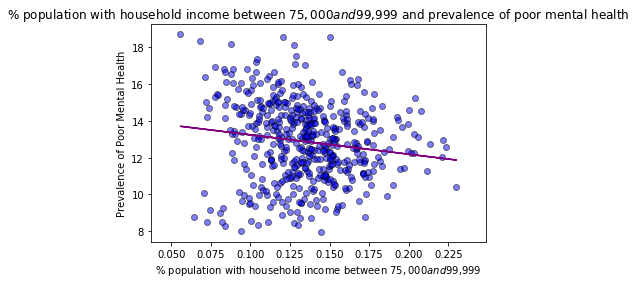

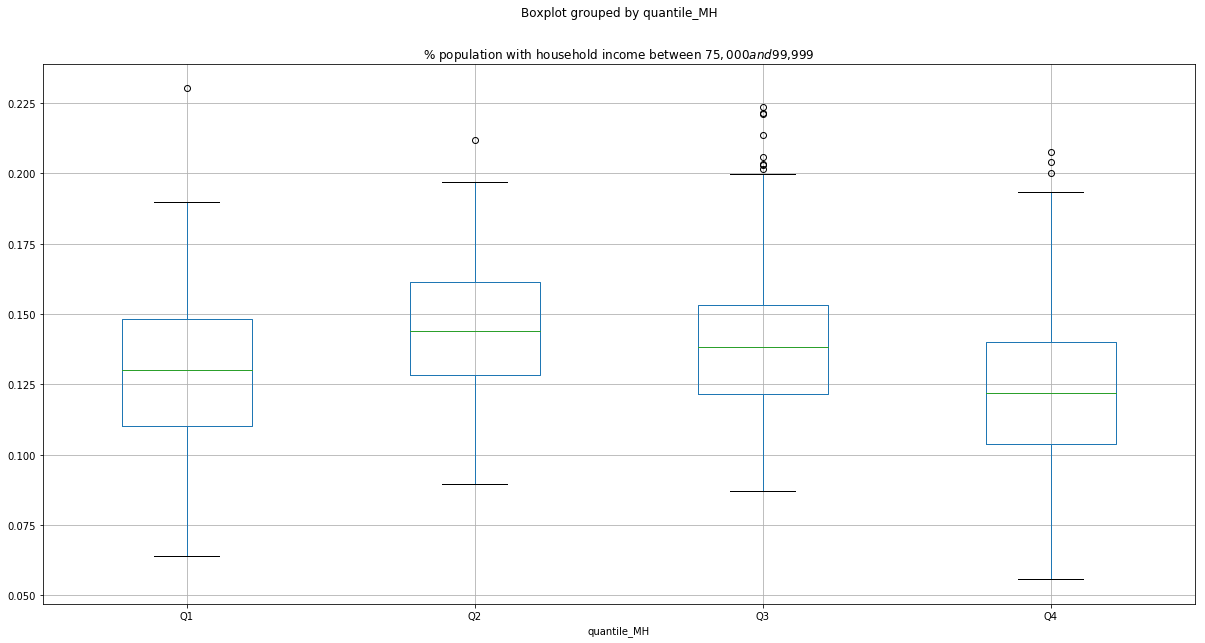

In [107]:
# Household income ($75,000-$99,999) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_hIncome_$75to99K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income between $75,000 and $99,999 and prevalence of poor mental health")
plt.xlabel("% population with household income between $75,000 and $99,999")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_$75to99K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_$75to99K'], p(df['percent_hIncome_$75to99K']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_hIncome_$75to99K', by='quantile_MH', figsize=(20, 10))
plt.title("% population with household income between $75,000 and $99,999")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_hIncome_$75to99K"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_hIncome_$75to99K"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_hIncome_$75to99K"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_hIncome_$75to99K"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_hIncome_$75to99K'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

F_onewayResult(statistic=355.15117235702604, pvalue=1.4365742763843218e-122)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2   -0.1451  -0.1761 -0.1141  True 
  Q1     Q3   -0.2479  -0.2742 -0.2217  True 
  Q1     Q4   -0.3196  -0.3461 -0.2932  True 
  Q2     Q3   -0.1028  -0.1309 -0.0748  True 
  Q2     Q4   -0.1745  -0.2028 -0.1463  True 
  Q3     Q4   -0.0717  -0.0946 -0.0488  True 
---------------------------------------------


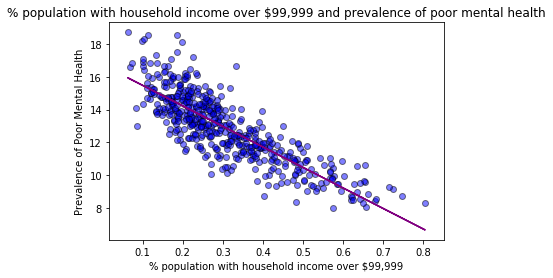

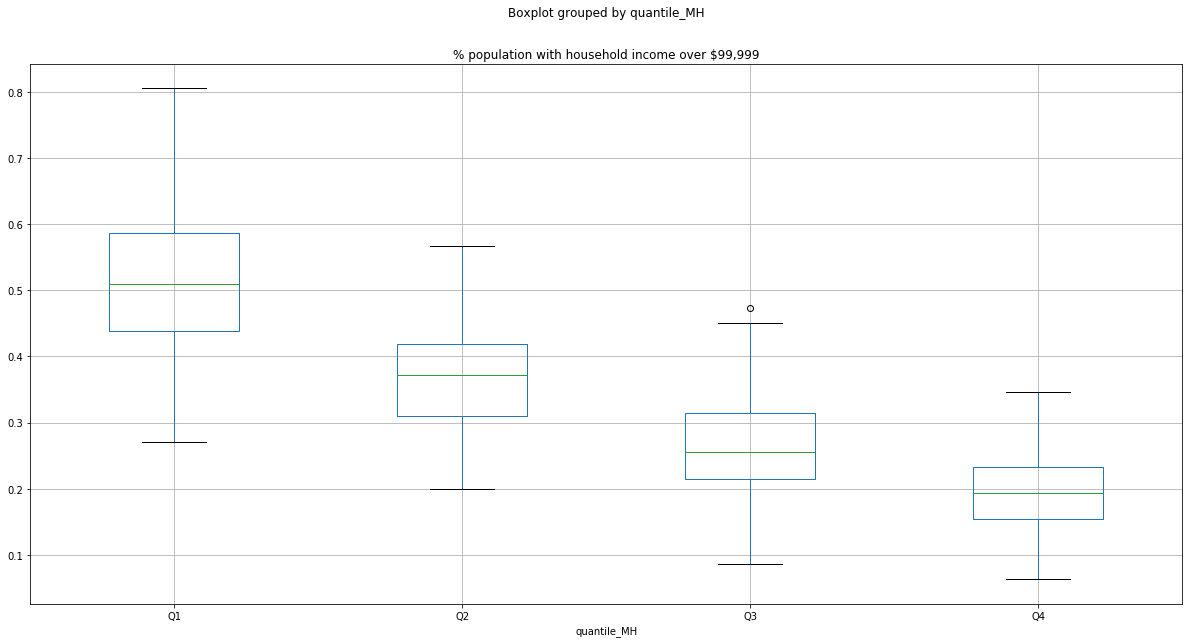

In [108]:
# Household income (over $99,999) and prevalence of poor mental health

# Scatter plot:
plt.scatter(df['percent_hIncome_over$99K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income over $99,999 and prevalence of poor mental health")
plt.xlabel("% population with household income over $99,999")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_over$99K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_over$99K'], p(df['percent_hIncome_over$99K']), 'purple')
#plt.show()

# Box plot
df.boxplot('percent_hIncome_over$99K', by='quantile_MH', figsize=(20, 10))
plt.title("% population with household income over $99,999")
#plt.show()

# Perform the ANOVA
group1 = df[df["quantile_MH"] == 'Q1']["percent_hIncome_over$99K"]
group2 = df[df["quantile_MH"] == 'Q2']["percent_hIncome_over$99K"]
group3 = df[df["quantile_MH"] == 'Q3']["percent_hIncome_over$99K"]
group4 = df[df["quantile_MH"] == 'Q4']["percent_hIncome_over$99K"]
print(stats.f_oneway(group1, group2, group3, group4))

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df_sorted['percent_hIncome_over$99K'], df_sorted['quantile_MH'], 0.05)
print(tukey_results)

# Exploring with multiple regressions analysis

In [ ]:
# Create DataFrame x to hold our independent variables
x = df[[
       'percent_age18to24', 'percent_age35to44',
       'percent_disability', 'percent_lessThanHS', 'percent_HS',
       'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_over$99K',
       'age18to64_%insured']]

## MODEL MH_8 : combining models MH_5 and MH_7 (R-squared = 0.89)
#### ALL INDEPENDENT VARIABLES IN THIS MODEL ARE STATISTICALLY SIGNIFICANT

In [ ]:
# Create DataFrame x to hold our independent variables
x = df[['UB_current_smoking', 'UB_less_sleep',
       'percent_age18to24', 'percent_age35to44',
       'percent_disability', 'percent_lessThanHS', 'percent_HS',
       'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_over$99K']]

In [ ]:
x = df[['UB_current_smoking', 'UB_less_sleep']]

## MODEL PH_1 : with most independent variables (R-squared = 0.93)

In [ ]:
# Create DataFrame x to hold our independent variables
x = df[['UB_binge_drinking', 'UB_current_smoking', 'UB_lack_physical_activity',
       'UB_obesity', 'UB_less_sleep',
       'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
       'PS_older_women_uptodate', 'population_CNI', 'age18to64',
       'percent_age18to24', 'percent_age25to34', 'percent_age35to44',
       'percent_age45to54', 'percent_age55to64', 'percent_male',
       'percent_female',
       'percent_disability', 'percent_lessThanHS', 'percent_HS',
       'percent_someCollege', 'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_$25to49K', 'percent_hIncome_$50to74K',
       'percent_hIncome_$75to99K', 'percent_hIncome_over$99K',
       'age18to64_%insured']]

## MODEL PH_2 : with 5 UB and 5 PS health indicators (R-squared = 0.86)

In [ ]:
# Create DataFrame x to hold our independent variables
x = df[['UB_binge_drinking', 'UB_current_smoking', 'UB_lack_physical_activity',
       'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
       'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
       'PS_older_women_uptodate']]

## MODEL PH_3 : with 4 UB and 3 PS health indicators (R-squared = 0.86)

In [ ]:
# Create DataFrame x to hold our independent variables
x = df[['UB_binge_drinking', 'UB_current_smoking', 'UB_lack_physical_activity',
        'UB_less_sleep', 'PS_lack_health_ins',
       'PS_routine_checkups', 'PS_dental_checkups']]

## MODEL PH_4 : with most demographic variables (R-squared = 0.89)

In [ ]:
# Create DataFrame x to hold our independent variables
x = df[[
       'percent_age18to24', 'percent_age25to34', 'percent_age35to44',
       'percent_age45to54', 'percent_age55to64', 'percent_male',
       'percent_female',
       'percent_disability', 'percent_lessThanHS', 'percent_HS',
       'percent_someCollege', 'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_$25to49K', 'percent_hIncome_$50to74K',
       'percent_hIncome_$75to99K', 'percent_hIncome_over$99K',
       'age18to64_%insured']]

## MODEL PH_5 : purged from model PH_4 (R-squared = 0.89)

In [ ]:
# Create DataFrame x to hold our independent variables
x = df[[
       'percent_age18to24', 'percent_age25to34',
       'percent_disability', 'percent_lessThanHS', 'percent_HS',
       'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_$25to49K']]

## MODEL PH_6 : combining models PH_3 and PH_5 (R-squared = 0.93)

In [ ]:
# Create DataFrame x to hold our independent variables
x = df[['UB_binge_drinking', 'UB_current_smoking', 'UB_lack_physical_activity',
        'UB_less_sleep', 'PS_lack_health_ins',
       'PS_routine_checkups', 'PS_dental_checkups',
       'percent_age18to24', 'percent_age25to34',
       'percent_disability', 'percent_lessThanHS', 'percent_HS',
       'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_$25to49K']]

## MODEL PH_7 : purging from model PH_6 (R-squared = 0.93)
#### ALL INDEPENDENT VARIABLES IN THIS MODEL ARE STATISTICALLY SIGNIFICANT

In [ ]:
# Create DataFrame x to hold our independent variables
x = df[['UB_current_smoking', 'UB_lack_physical_activity',
        'UB_less_sleep',
       'percent_age18to24', 'percent_age25to34',
       'percent_disability', 'percent_lessThanHS',
       'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_$25to49K']]

In [ ]:
x = df[['HO_poor_mental_health']]

## RUN THE MODEL on Mental Health outcome

In [ ]:
# Create DataFrame y to hold our dependent variable
y = df[['HO_poor_mental_health']]

# Split x into 80% training set and 20% testing set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# Build the linear regression model & fit the model using x_train and y_train
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
model = mlr.fit(x_train, y_train)

# Use the model to predict y-values from x_test
y_predict = mlr.predict(x_test)

# Visualize the fit
plt.scatter(y_test, y_predict, alpha=0.7)

plt.xlabel("Prevalence of poor MH")
plt.ylabel("Predicted prevalence of poor MH")
plt.title("Actual Prevalence of Poor MH vs Predicted Prevalence of Poor MH")

plt.show()

In [ ]:
# Looking at the regression intercept and coefficients
print('Intercept: \n', mlr.intercept_)
print('Coefficients: \n', mlr.coef_)

# Evaluate accuracy of our model (R-square)
print("Train score:")
print(mlr.score(x_train, y_train))

print("Test score:")
print(mlr.score(x_test, y_test))

In [ ]:
# with statsmodels
import statsmodels.api as sm
x = sm.add_constant(x) # adding a constant
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

### ------------------------------